In [1]:
#!unzip dl-2025-study-competition-2.zip

Спойлер: лучшая модель - 4, а генератор у меня волшебный.

**1) Проанализировать данные, посмотреть на баланс классов, посмотреть на представителей классов, поизучать текста, сделать выводы. (0.5 балла).**

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn.modules.loss import _Loss

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import clear_output
from wordcloud import WordCloud

import re
import os
import numpy as np
import pandas as pd
from collections import Counter

from pymorphy2 import MorphAnalyzer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer

from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

from transformers import AutoTokenizer, AutoModel
from torch.optim import AdamW
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence
from torch.nn.modules.loss import _Loss

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
tqdm.pandas()
from IPython.display import clear_output
import re
import os
import sys
from collections import Counter, defaultdict

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import RussianStemmer, SnowballStemmer

import pymorphy2
from gensim.models import Word2Vec

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.metrics import f1_score

from transformers import (
    AutoTokenizer, 
    AutoModel,
    GPT2LMHeadModel, 
    GPT2Tokenizer,
    AdamW
)
from wordcloud import WordCloud

In [13]:
import torch
print(f"torch: {torch.__version__}")

import transformers
print(f"transformers: {transformers.__version__}")

import numpy
print(f"numpy: {numpy.__version__}")

import pandas
print(f"pandas: {pandas.__version__}")

import matplotlib
print(f"matplotlib: {matplotlib.__version__}")

import seaborn
print(f"seaborn: {seaborn.__version__}")

import nltk
print(f"nltk: {nltk.__version__}")

import gensim
print(f"gensim: {gensim.__version__}")

import sklearn
print(f"sklearn: {sklearn.__version__}")

import pymorphy2
print(f"pymorphy2: {pymorphy2.__version__}")

import wordcloud
print(f"wordcloud: {wordcloud.__version__}")

import tqdm
print(f"tqdm: {tqdm.__version__}")

torch: 2.0.1+cu118
transformers: 4.30.1
numpy: 1.22.4
pandas: 1.5.3
matplotlib: 3.7.1
seaborn: 0.12.2
nltk: 3.8.1
gensim: 4.3.1
sklearn: 1.2.2
pymorphy2: 0.9.1
wordcloud: 1.8.2.2
tqdm: 4.65.0


In [3]:
df_sample = pd.read_csv("sample_submission.csv")
df_sample.head()

,id,labels
0,29568,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
1,29569,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
2,29570,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
3,29571,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
4,29572,0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


In [4]:
df = pd.read_csv("train.csv")
df

,id,text,labels
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0
...,...,...,...
29563,29563,Выступление Симфо-группы TEODOR\n⠀\n22 июля в ...,0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 1 1 1 1 0
29564,29564,"🔤\nЮЗИКЛ ""МОНТЕ-КРИСТО"" ТЕАТР ОПЕРЕТТЫ\nЭто оч...",1 1 1 0 0 0 0 1 0 1 1 1 0 1 1 0 1 1 1 0
29565,29565,РАСПИСАНИЕ БЕСПЛАТНЫХ ЭКСКУРСИЙ\nв октябре 202...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
29566,29566,Долгожданный концерт Надежды Кадышевой в Рязан...,1 0 1 0 0 0 0 1 0 1 1 1 0 1 1 0 0 1 1 0


In [5]:
df = df.drop_duplicates(subset=["text", "labels"], keep='first')
df.shape[0]

27454

Удалили 2114 строк, так как они были дубликаты

Что-то похожее на рекламу, предположительно у нас 20 классов

In [17]:
labels = df.loc[0, 'labels'].split()
labels, len(labels)

(['1',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '1',
  '0',
  '0',
  '0',
  '1',
  '1',
  '1',
  '1',
  '1',
  '0',
  '0',
  '1'],
 20)

In [18]:
labels = df['labels'].values
labels = [[int(x) for x in row.split() if x.strip()] for row in df['labels']]
labels = np.array(labels)

In [19]:
labels.shape

(27454, 20)

In [20]:
num_classes = len(labels[0])

In [21]:
num_classes

20

In [22]:
labels[:, 0]

array([1, 0, 0, ..., 1, 1, 1])

In [23]:
plots = {}
for idx in range(20):
  plots[idx] = labels[:, idx].sum()

In [24]:
plots

{0: 14887,
 1: 17807,
 2: 1376,
 3: 1653,
 4: 16868,
 5: 97,
 6: 196,
 7: 21178,
 8: 21541,
 9: 19174,
 10: 11853,
 11: 17256,
 12: 21733,
 13: 21347,
 14: 20907,
 15: 13753,
 16: 20295,
 17: 21971,
 18: 22649,
 19: 5260}

<BarContainer object of 20 artists>

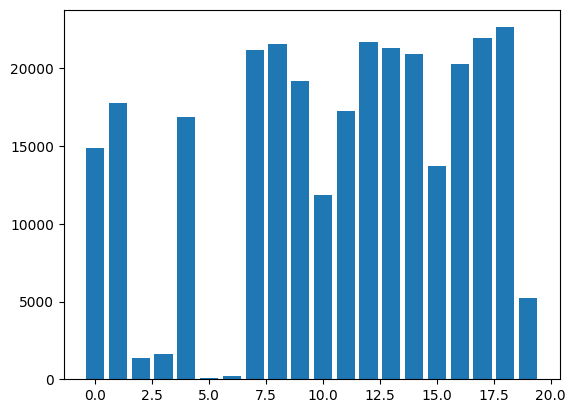

In [25]:
plt.bar(plots.keys(), plots.values())

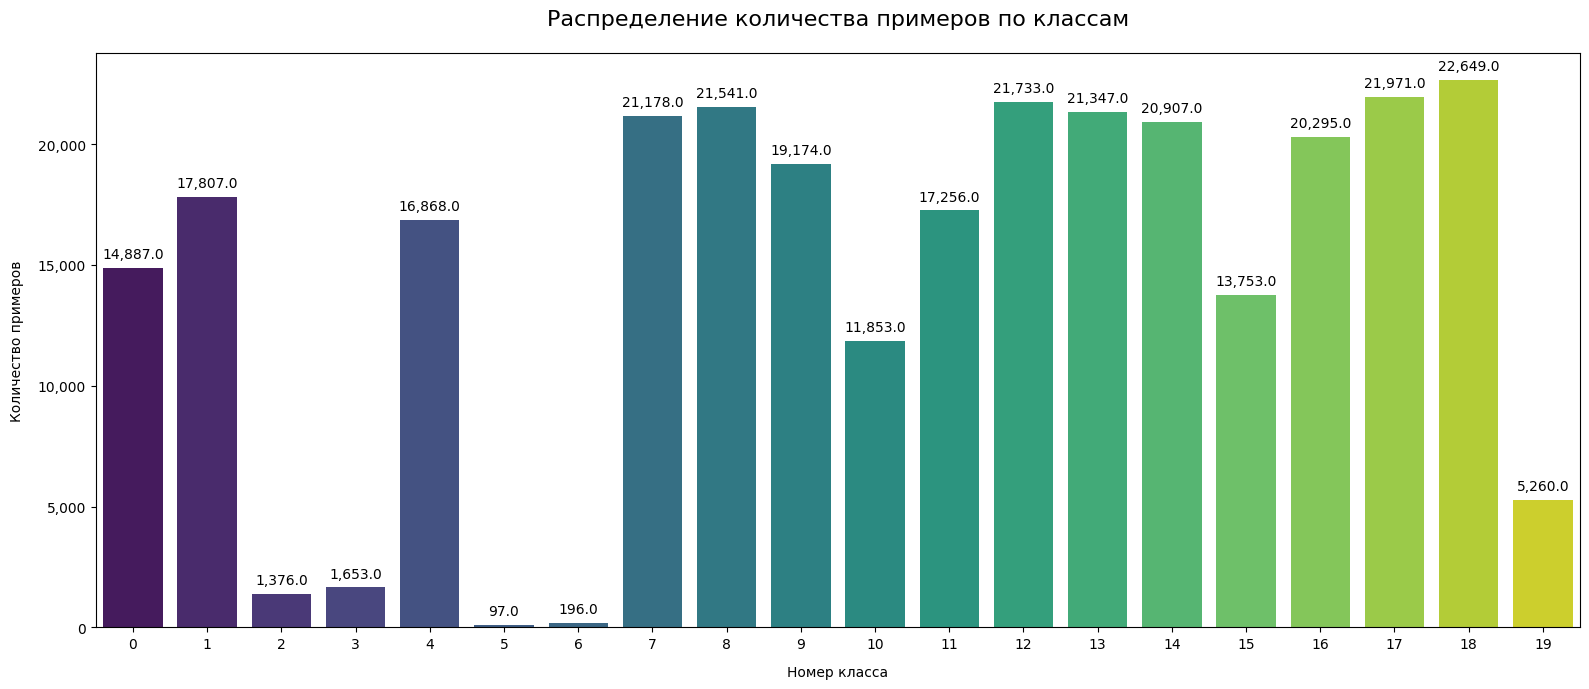

In [15]:
graf = pd.DataFrame({
    'Class': list(plots.keys()),
    'Count': list(plots.values())
}).sort_values('Class')

plt.figure(figsize=(16, 7))

ax = sns.barplot(
    data=graf,
    x='Class',
    y='Count',
    palette="viridis",
    saturation=0.8
)

for p in ax.patches:
    ax.annotate(
        format(p.get_height(), ','),
        (p.get_x() + p.get_width() / 2., p.get_height()),
        ha='center',
        va='center',
        xytext=(0, 10),
        textcoords='offset points',
        fontsize=10
    )

# Настройка оформления
plt.title('Распределение количества примеров по классам', pad=20, fontsize=16)
plt.xlabel('Номер класса', labelpad=10)
plt.ylabel('Количество примеров', labelpad=10)
plt.xticks(range(20))  # Все 20 классов

# Улучшаем читаемость больших чисел
ax.get_yaxis().set_major_formatter(
    plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x)))
)

plt.tight_layout()
plt.show()

Видим дисбаланс классов, у нас очень мало примеров для 2, 3,5,6 и 19 классов


В тексте ссылки, ники, дата, эмодзи и тд, этот текст требуется в тщательной обработке

**2) Проанализировать, какие очистки текста необходимы под разные способы токенизации и задания эмбеддингов для этой задачи: (1) tf-idf + любая нейронная сеть; (2) w2v + любая нейронная сеть; (3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях; (4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях; (5) эмбеддер + решение на bert-like моделях (любой вид). Создать пайплайны очистки текста и очистить (1.5 балла).**

(1) tf-idf + любая нейронная сеть 1 способ

In [17]:
text = df.loc[0, 'text']
def clean_text(text):
  text = " ".join(text.split('\n'))
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\s+', ' ', text)
  return text

cleaned_text = clean_text(text)
text, cleaned_text

('15 января\nДетская развлекательная программа\n15-00 бесплатно\n❗️\n@\ncafeotdyh\nКафе "Отдых"\n📍\nЗапись обязательно +73472228532',
 '15 января детская развлекательная программа 1500 бесплатно cafeotdyh кафе отдых запись обязательно 73472228532')

In [18]:
df = df.copy() 
df['cleaned_text'] = df['text'].apply(clean_text)
df.head()

,id,text,labels,cleaned_text
0,0,15 января\nДетская развлекательная программа\n...,1 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 0 0 1,15 января детская развлекательная программа 15...
1,1,13 и 14 августа\nВыходные в Меге\nhttps://t.me...,0 0 0 1 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1,13 и 14 августа выходные в меге httpstmemegauf...
2,2,Йокнапатофа\nПостановка Театр им. Маяковского\...,0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1,йокнапатофа постановка театр им маяковского би...
3,3,Впервые в Уфе танцевальная терапия в группе с ...,1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 0,впервые в уфе танцевальная терапия в группе с ...
4,4,"🎹\nGRAND PIANO COMPETITION\n🎹\nДрузья, сегодня...",1 1 0 0 0 0 0 1 1 0 0 1 1 1 1 0 1 1 1 0,grand piano competition друзья сегодня открыт...


In [19]:
tfidf = TfidfVectorizer()
X_tfid = tfidf.fit_transform(df['cleaned_text']).toarray()
X_tfid

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [20]:
X_tfid.shape

(27454, 124352)

In [21]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X, y = self.X[idx], self.y[idx]
    X, y = torch.tensor(X).float(), torch.tensor(y).float()
    return X, y

In [22]:
ds = MyDataset(X_tfid, labels)
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [23]:
X, y = next(iter(dl))
X, y

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([[1., 1., 0.,  ..., 1., 1., 0.],
         [1., 1., 0.,  ..., 1., 1., 0.],
         [0., 1., 0.,  ..., 0., 1., 0.],
         ...,
         [1., 1., 0.,  ..., 1., 1., 0.],
         [0., 0., 0.,  ..., 1., 1., 0.],
         [1., 0., 0.,  ..., 1., 1., 0.]]))

In [24]:
class Model(nn.Module):
  def __init__(self, input_size, classes=20) -> None:
    super().__init__()
    self.nn = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(64, classes),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.nn(x)

In [27]:
# model = Model(15000, 20)

# device = torch.device('cpu')
# criterion = nn.BCELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# for epoch in range(10):
#   model.train()
#   total_loss = 0
#   for X, y in dl:
#     optimizer.zero_grad()
#     y_pred = model(X)
#     loss = criterion(y_pred, y)
#     loss.backward()
#     optimizer.step()
#     total_loss += loss.item()

#   print(f"{epoch}, loss {total_loss/len(dl)}")

In [28]:
# !pip install nltk gensim numpy==1.20.1 scipy==1.10.1

(2) w2v + любая нейронная сеть;

In [29]:
w2v = Word2Vec(sentences=df['cleaned_text'], vector_size=100, window=4, min_count=1)

def embedding_w2v(tokens):
  vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
  return vecs

X_w2v = df['cleaned_text'].apply(lambda row: embedding_w2v(row))
X_w2v

0        [[0.43699935, -1.8527511, -1.0106736, -1.57884...
1        [[0.43699935, -1.8527511, -1.0106736, -1.57884...
2        [[-0.50189596, 1.1171631, -0.13403878, 0.29493...
3        [[-0.16290593, 0.31996787, -0.19523728, -0.051...
4        [[-0.08443773, 0.38605726, 0.13504295, 0.22539...
                               ...                        
29562    [[-0.2094692, 0.3767196, -0.0054020663, -0.080...
29563    [[-0.16290593, 0.31996787, -0.19523728, -0.051...
29564    [[-0.08443773, 0.38605726, 0.13504295, 0.22539...
29565    [[0.0318507, 0.21568339, 0.3143434, 0.02952103...
29566    [[-0.11282216, 0.7601068, -0.42523986, -0.3493...
Name: cleaned_text, Length: 27454, dtype: object

In [30]:
ds = MyDataset(X_w2v, labels)
dl = DataLoader(ds, batch_size=64, shuffle=True)

In [34]:
def embedding_w2v(text):
    tokens = text.split()
    vecs = [w2v.wv[word] for word in tokens if word in w2v.wv]
    return np.mean(vecs, axis=0) if len(vecs) > 0 else np.zeros(w2v.vector_size)

X_w2v = np.array([embedding_w2v(text) for text in df["cleaned_text"]])

# Dataset и DataLoader
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

ds_w2v = MyDataset(X_w2v, labels)
dl_w2v = DataLoader(ds_w2v, batch_size=64, shuffle=True)

# Модель
class Model(nn.Module):
    def __init__(self, input_size, classes=20):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

# Обучение
model_w2v = Model(input_size=100)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model_w2v.parameters(), lr=0.001)

for epoch in range(10):
    model_w2v.train()
    total_loss = 0
    for X, y in dl_w2v:
        optimizer.zero_grad()
        y_pred = model_w2v(X)
        loss = criterion(y_pred, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch}, Loss: {total_loss / len(dl_w2v)}")

Epoch 0, Loss: 0.42640762555571426
Epoch 1, Loss: 0.38591576074108935
Epoch 2, Loss: 0.3778946985314776
Epoch 3, Loss: 0.3731548850769763
Epoch 4, Loss: 0.3706531284989177
Epoch 5, Loss: 0.3687939338195018
Epoch 6, Loss: 0.367169883423474
Epoch 7, Loss: 0.3662592655434197
Epoch 8, Loss: 0.3648152725124137
Epoch 9, Loss: 0.36337045001816914


другой вариант

In [35]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/jupyter/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [36]:
def preprocess_text(text, method='lemmatize'):
    # приводим весь текст к нижнему регистру 
    text = text.lower()
    # замена всего некиррилического на пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    # могли появиться повторные пробелы - удаляем их
    text = re.sub(r'\s+', ' ', text).strip()
    # токенизация (разбиение на слова)
    tokens = text.split()
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)

In [37]:
def preprocess_text(text, method='lemmatize'):
    # приводим весь текст к нижнему регистру 
    text = text.lower()
    # замена всего некиррилического на пробелы
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
# Email
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
# URL
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)
    # могли появиться повторные пробелы - удаляем их
    text = re.sub(r'\s+', ' ', text).strip()
    # токенизация (разбиение на слова)
    tokens = text.split()
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)


In [38]:
morph = pymorphy2.MorphAnalyzer()
stemmer = RussianStemmer()
stop_words = set(stopwords.words('russian'))
df['processed_text'] = df['text'].progress_apply(lambda x: preprocess_text(x, method='lemmatize'))

100%|██████████| 27454/27454 [06:33<00:00, 69.71it/s]


In [42]:
train_df_less, test_df_less = train_test_split(df, test_size=0.2, random_state=42)

In [43]:
all_text = ' '.join(train_df_less['processed_text'])
word_freq = Counter(all_text.split())
most_common = dict(word_freq.most_common(100))
least_common = dict(word_freq.most_common()[:-101:-1])

In [44]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(train_df_less['processed_text'])
doc_freq = np.sum(X > 0, axis=0).A1
total_docs = X.shape[0]
words = np.array(vectorizer.get_feature_names_out())
mask = (doc_freq > 3) & (doc_freq < total_docs)
selected_words = set(words[mask])
train_df_less['filtered_text'] = train_df_less['processed_text'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))
test_df_less['filtered_text'] = test_df_less['processed_text'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))

100%|██████████| 5491/5491 [00:00<00:00, 78816.34it/s]


In [47]:
df['filtered_text'] = df['processed_text'].progress_apply(lambda x: ' '.join([word for word in x.split() if word in selected_words]))

100%|██████████| 27454/27454 [00:00<00:00, 78090.58it/s]


In [48]:
tfidf = TfidfVectorizer()
X_tfid = tfidf.fit_transform(df['filtered_text']).toarray()
# X_tfid.shape - (21963, 15536)
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    X, y = self.X[idx], self.y[idx]
    X, y = torch.tensor(X).float(), torch.tensor(y).float()
    return X, y
ds = MyDataset(X_tfid, labels)
dl = DataLoader(ds, batch_size=64, shuffle=True)
X, y = next(iter(dl))
class Model(nn.Module):
  def __init__(self, input_size, classes=20) -> None:
    super().__init__()
    self.nn = nn.Sequential(
        nn.Linear(in_features=input_size, out_features=512),
        nn.ReLU(),
        nn.Linear(512, 256),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(256, 128),
        nn.ReLU(),
        nn.Linear(128, 64),
        nn.ReLU(),
        nn.Dropout(p=.2),
        nn.Linear(64, classes),
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.nn(x)
model = Model(15534, 20)

device = torch.device('cpu')
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(15):
  model.train()
  total_loss = 0
  for X, y in dl:
    optimizer.zero_grad()
    y_pred = model(X)
    loss = criterion(y_pred, y)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  print(f"{epoch}, loss {total_loss/len(dl)}")

0, loss 0.3879061795614816
1, loss 0.28702590501669684
2, loss 0.2520024272111746
3, loss 0.2313810090918641
4, loss 0.21215657403558005
5, loss 0.19753090155013514
6, loss 0.18396982401262074
7, loss 0.1724909751009552
8, loss 0.16271881557705797
9, loss 0.15380163072219818
10, loss 0.14613297133595793
11, loss 0.13835742519104674
12, loss 0.13177867852029823
13, loss 0.1248082975338111
14, loss 0.1193082610661889


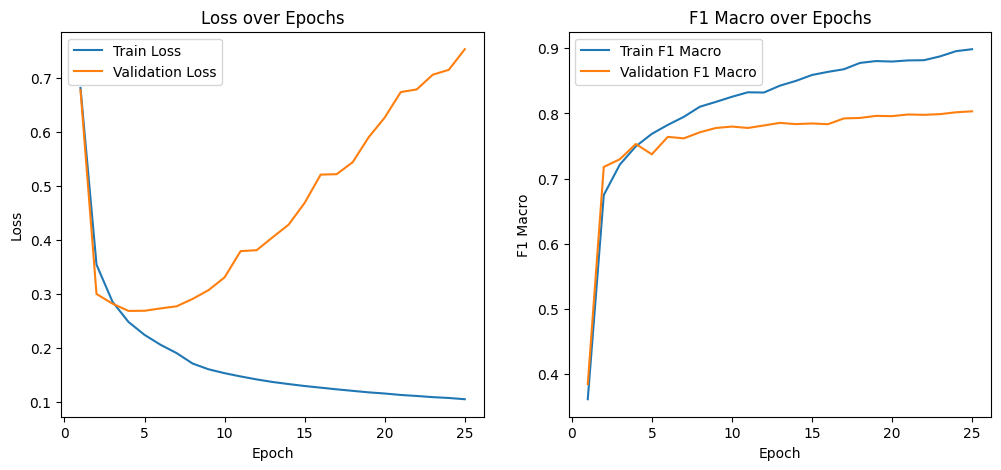

100%|██████████| 25/25 [01:37<00:00,  3.91s/it]

Epoch 25/25 | LR: 0.001000 | Train Loss: 0.1044, Train F1: 0.8985 | Val Loss: 0.7539, Val F1: 0.8033
EarlyStopping counter: 17 out of 3
EarlyStopping counter: 17 out of 3


In [50]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        X, y = self.X[idx], self.y[idx]
        X, y = torch.tensor(X).float(), torch.tensor(y).float()
        return X, y

class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    lr = warmup_lr_start + (base_lr - warmup_lr_start) * (epoch / warmup_epochs)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return optimizer

class Model(nn.Module):
    def __init__(self, input_size, classes=20) -> None:
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(in_features=input_size, out_features=512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

def calculate_f1_macro(outputs, targets, threshold=0.5):
    # Convert probabilities to binary predictions
    predicted = (outputs > threshold).float()
    
    # Calculate true positives, false positives, false negatives for each class
    tp = (predicted * targets).sum(0)
    fp = (predicted * (1 - targets)).sum(0)
    fn = ((1 - predicted) * targets).sum(0)
    
    # Calculate precision and recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return macro F1 (average across classes)
    return f1.mean().item()

# Create dataset and dataloaders
dataset = MyDataset(X_tfid, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize model, loss, optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(X_tfid.shape[1], 20).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training setup
base_lr = 0.01
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
loss_switched = False
optimizer_switched = False

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)
early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)
best_val_f1 = 0

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_outputs.append(outputs.detach().cpu())
        all_targets.append(targets.detach().cpu())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_outputs)
    train_targets = torch.cat(all_targets)
    train_f1 = calculate_f1_macro(train_outputs, train_targets)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_outputs = []
    val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            val_outputs.append(outputs.cpu())
            val_targets.append(targets.cpu())
    
    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)
    val_f1 = calculate_f1_macro(val_outputs, val_targets)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_first_tf_idf_classification_model.pth')
        print(f'Best Val F1 Macro: {best_val_f1:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    clear_output(wait=True)
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
    plt.plot(range(1, len(val_losses)+1), val_losses, label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title("Loss over Epochs")
    plt.legend()

    plt.subplot(1,2,2)
    plt.plot(range(1, len(train_f1s)+1), train_f1s, label="Train F1 Macro")
    plt.plot(range(1, len(val_f1s)+1), val_f1s, label="Validation F1 Macro")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Macro")
    plt.title("F1 Macro over Epochs")
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    early_stopping_loss_switch(val_loss, model)
    if early_stopping_loss_switch.early_stop and not loss_switched:
        print("No improvement in validation loss. Switching loss function to custom multiclass loss.")
        # You would need to define your CustomMultiClassLoss
        # criterion = CustomMultiClassLoss()
        loss_switched = True
        early_stopping_loss_switch = EarlyStopping(patience=3, verbose=True)

    early_stopping_optimizer_switch(val_loss, model)
    if early_stopping_optimizer_switch.early_stop and not optimizer_switched:
        print("No improvement after loss switch. Switching optimizer to Adam.")
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        base_lr = 0.001
        optimizer_switched = True
        early_stopping_optimizer_switch = EarlyStopping(patience=3, verbose=True)

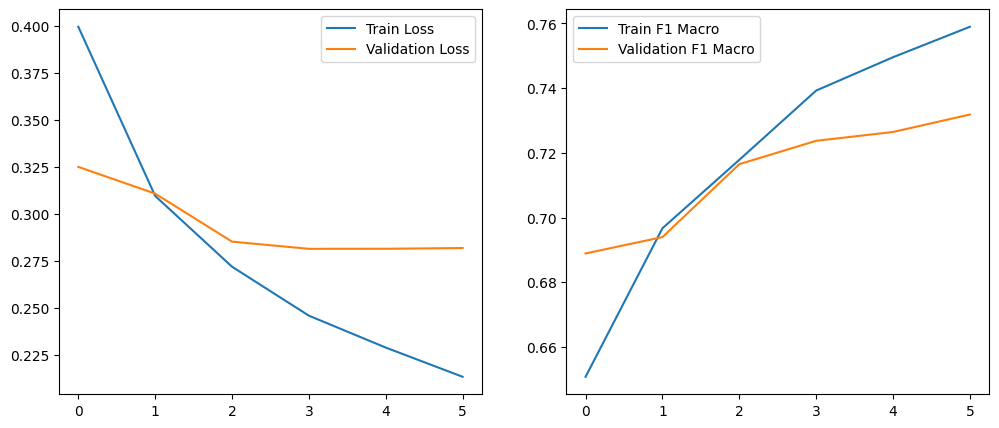

  6%|▌         | 6/100 [00:23<05:37,  3.59s/it]

Epoch 6: Train Loss: 0.2131, Val Loss: 0.2818 | Train F1: 0.7590, Val F1: 0.7318


  6%|▌         | 6/100 [00:25<06:44,  4.30s/it]

EarlyStopping counter: 3 out of 3
Обучение остановлено из-за отсутствия улучшений!
Лучшая модель загружена!


In [52]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def calculate_f1_macro(outputs, targets, threshold=0.5):
    # Convert probabilities to binary predictions
    predicted = (outputs > threshold).float()
    
    # Calculate true positives, false positives, false negatives for each class
    tp = (predicted * targets).sum(0)
    fp = (predicted * (1 - targets)).sum(0)
    fn = ((1 - predicted) * targets).sum(0)
    
    # Calculate precision and recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return macro F1 (average across classes)
    return f1.mean().item()

# Dataset и Model (как в вашем коде)
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

class Model(nn.Module):
    def __init__(self, input_size, classes=20):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = MyDataset(X_tfid, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = Model(X_tfid.shape[1], 20).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=3, verbose=True)

# Обучение с EarlyStopping
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []

for epoch in tqdm(range(100)):  # Большое число эпох (остановится через EarlyStopping)
    model.train()
    running_loss = 0.0
    all_train_outputs = []
    all_train_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_train_outputs.append(outputs.detach().cpu())
        all_train_targets.append(targets.detach().cpu())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_train_outputs)
    train_targets = torch.cat(all_train_targets)
    train_f1 = calculate_f1_macro(train_outputs, train_targets)

    # Валидация
    model.eval()
    running_val_loss = 0.0
    all_val_outputs = []
    all_val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            all_val_outputs.append(outputs.cpu())
            all_val_targets.append(targets.cpu())

    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(all_val_outputs)
    val_targets = torch.cat(all_val_targets)
    val_f1 = calculate_f1_macro(val_outputs, val_targets)

    # Сохраняем метрики
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Проверяем EarlyStopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Обучение остановлено из-за отсутствия улучшений!")
        break

    # Обновляем LR
    scheduler.step()

    # Вывод статистики
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1 Macro')
    plt.plot(val_f1s, label='Validation F1 Macro')
    plt.legend()
    plt.show()

    print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} | Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

# Загружаем лучшую модель
model.load_state_dict(torch.load('checkpoint.pt'))
print("Лучшая модель загружена!")

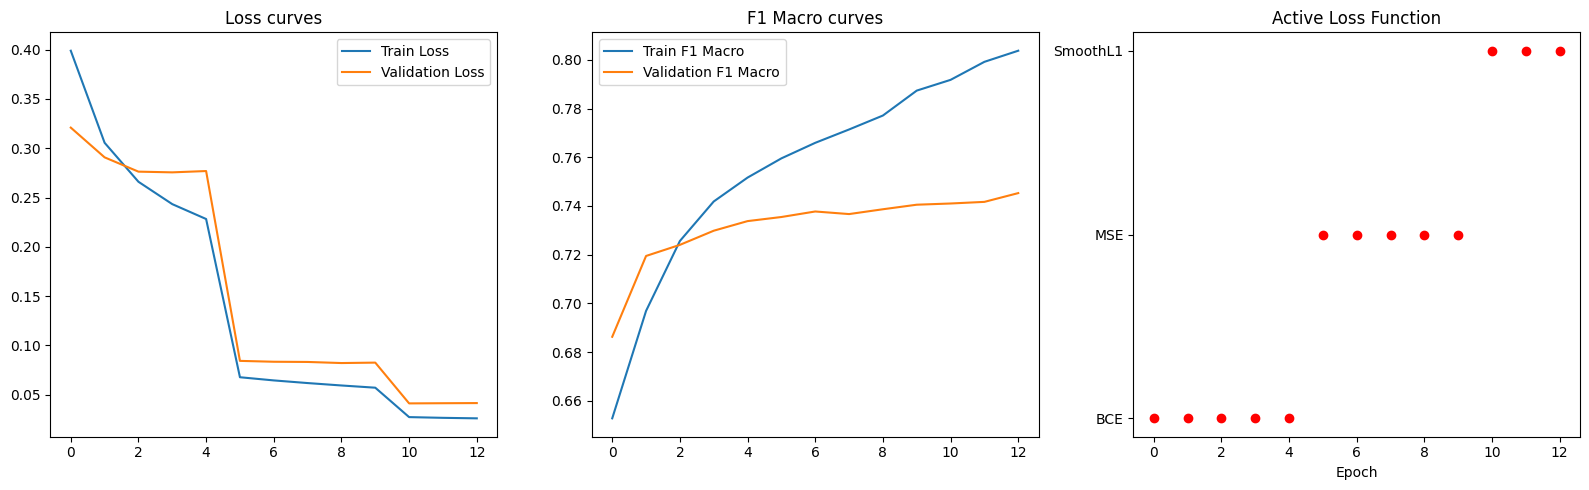

 13%|█▎        | 13/100 [00:52<05:21,  3.69s/it]

Epoch 13:
Current loss: SMOOTH_L1
Train Loss: 0.0261, Val Loss: 0.0416
Train F1: 0.8038, Val F1: 0.7453


 13%|█▎        | 13/100 [00:55<06:08,  4.24s/it]

EarlyStopping counter: 3 out of 3
Обучение остановлено из-за отсутствия улучшений!
Лучшая модель загружена!


In [53]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss
        
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def calculate_f1_macro(outputs, targets, threshold=0.5):
    # Convert probabilities to binary predictions
    predicted = (outputs > threshold).float()
    
    # Calculate true positives, false positives, false negatives for each class
    tp = (predicted * targets).sum(0)
    fp = (predicted * (1 - targets)).sum(0)
    fn = ((1 - predicted) * targets).sum(0)
    
    # Calculate precision and recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return macro F1 (average across classes)
    return f1.mean().item()

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

class Model(nn.Module):
    def __init__(self, input_size, classes=20):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

# Loss switcher class
class LossSwitcher:
    def __init__(self):
        self.losses = {
            'bce': nn.BCELoss(),
            'mse': nn.MSELoss(),
            'smooth_l1': nn.SmoothL1Loss()
        }
        self.current_loss = 'bce'
        
    def switch(self, epoch):
        # Implement any switching logic you want
        if epoch < 5:
            self.current_loss = 'bce'
        elif 5 <= epoch < 10:
            self.current_loss = 'mse'
        else:
            self.current_loss = 'smooth_l1'
            
    def __call__(self, outputs, targets):
        return self.losses[self.current_loss](outputs, targets)

# Инициализация
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dataset = MyDataset(X_tfid, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

model = Model(X_tfid.shape[1], 20).to(device)
criterion = LossSwitcher()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=3, verbose=True)

# Обучение с EarlyStopping и свитчем лоссов
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
current_loss_names = []  # Для отображения используемого лосса

for epoch in tqdm(range(100)):
    # Переключаем лосс в зависимости от эпохи
    criterion.switch(epoch)
    current_loss_names.append(criterion.current_loss)
    
    model.train()
    running_loss = 0.0
    all_train_outputs = []
    all_train_targets = []

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_train_outputs.append(outputs.detach().cpu())
        all_train_targets.append(targets.detach().cpu())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_train_outputs)
    train_targets = torch.cat(all_train_targets)
    train_f1 = calculate_f1_macro(train_outputs, train_targets)

    # Валидация
    model.eval()
    running_val_loss = 0.0
    all_val_outputs = []
    all_val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            all_val_outputs.append(outputs.cpu())
            all_val_targets.append(targets.cpu())

    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(all_val_outputs)
    val_targets = torch.cat(all_val_targets)
    val_f1 = calculate_f1_macro(val_outputs, val_targets)

    # Сохраняем метрики
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Проверяем EarlyStopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Обучение остановлено из-за отсутствия улучшений!")
        break

    # Обновляем LR
    scheduler.step()

    # Вывод статистики
    clear_output(wait=True)
    plt.figure(figsize=(16, 5))
    
    plt.subplot(1, 3, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.title('Loss curves')
    plt.legend()
    
    plt.subplot(1, 3, 2)
    plt.plot(train_f1s, label='Train F1 Macro')
    plt.plot(val_f1s, label='Validation F1 Macro')
    plt.title('F1 Macro curves')
    plt.legend()
    
    plt.subplot(1, 3, 3)
    plt.plot(current_loss_names, marker='o', linestyle='', color='r')
    plt.title('Active Loss Function')
    plt.yticks([0, 1, 2], ['BCE', 'MSE', 'SmoothL1'])
    plt.xlabel('Epoch')
    
    plt.tight_layout()
    plt.show()

    print(f'Epoch {epoch+1}:')
    print(f'Current loss: {criterion.current_loss.upper()}')
    print(f'Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')
    print(f'Train F1: {train_f1:.4f}, Val F1: {val_f1:.4f}')

# Загружаем лучшую модель
model.load_state_dict(torch.load('checkpoint.pt'))
print("Лучшая модель загружена!")

0.80539 - на тесте

(2) w2v + любая нейронная сеть;

In [57]:
window_size = 5
embed_dim = 300
min_count = 1
batch_size = 64
epochs = 10
lr = 0.01

In [58]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text_for_word2vec(text, method='lemmatize'):
    # приводим весь текст к нижнему регистру 
    text = text.lower()
    
    # замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # удаляем всё, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # удаляем повторные пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # токенизация
    tokens = text.split()
    
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    
    # удаляем только очень короткие слова (длиной 1-2 символа)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

In [59]:
morph = pymorphy2.MorphAnalyzer()
stemmer = RussianStemmer()
stop_words = set(stopwords.words('russian'))
df['w2v'] = df['text'].progress_apply(lambda x: preprocess_text_for_word2vec(x, method='lemmatize'))

100%|██████████| 27454/27454 [06:45<00:00, 67.64it/s]


In [60]:
train_df_w2v, test_df_w2v = train_test_split(df, test_size=0.2, random_state=42)

In [61]:
train_tokens = train_df_w2v['w2v'].values
test_tokens  = test_df_w2v['w2v'].values

In [62]:
w2v = Word2Vec(sentences=df['w2v'], vector_size=100, window=4, min_count=1)

def embedding_w2v(tokens):
  vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
  return vecs

X_w2v = df['w2v'].apply(lambda row: embedding_w2v(row))
X_w2v

0        [[0.49317586, -0.3698297, -0.53719056, -0.5106...
1        [[0.07889867, -0.31733385, -0.34318352, 0.5466...
2        [[-0.1974291, -0.26591578, -0.4506553, -0.1535...
3        [[-0.06832366, -0.47728443, 0.3348957, -0.5743...
4        [[0.12752536, 0.074210025, 0.12291885, -0.1030...
                               ...                        
29562    [[0.07889867, -0.31733385, -0.34318352, 0.5466...
29563    [[-0.06832366, -0.47728443, 0.3348957, -0.5743...
29564    [[-1.0598533, 0.30663595, -0.66734314, -0.2004...
29565    [[0.3407835, -0.12355232, 0.15703438, -0.10220...
29566    [[0.12752536, 0.074210025, 0.12291885, -0.1030...
Name: w2v, Length: 27454, dtype: object

In [63]:
counter = Counter(w for doc in train_tokens for w in doc.split())
vocab   = ['<PAD>'] + [w for w, c in counter.items() if c >= min_count]
word2idx = {w: i for i, w in enumerate(vocab)}
idx2word = {i: w for w, i in word2idx.items()}
vocab_size = len(vocab)

In [38]:
# word2idx

In [39]:
# idx2word

In [64]:
sg_pairs = []
for doc in train_tokens:
    ids = [word2idx[w] for w in doc.split() if w in word2idx]
    for i, center in enumerate(ids):
        for j in range(i-window_size, i+window_size+1):
            if j!=i and 0 <= j < len(ids):
                sg_pairs.append((center, ids[j]))
class SkipGramDataset(Dataset):
    def __init__(self, pairs):
        self.centers, self.contexts = zip(*pairs)
    def __len__(self):
        return len(self.centers)
    def __getitem__(self, idx):
        return torch.LongTensor([self.centers[idx]]), torch.LongTensor([self.contexts[idx]])

In [65]:
sg_loader = DataLoader(SkipGramDataset(sg_pairs), batch_size=batch_size, shuffle=True)

In [66]:
# sg_pairs

In [67]:
class SkipGramModel(nn.Module):
    def __init__(self, vocab_size, embed_dim):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, embed_dim)
        self.out = nn.Linear(embed_dim, vocab_size)
    def forward(self, center_idx):
        v = self.emb(center_idx).squeeze(1)
        logits = self.out(v)
        return logits

In [68]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sg_model = SkipGramModel(vocab_size, embed_dim).to(device)

In [38]:
criterion = nn.CrossEntropyLoss()
sg_opt   = torch.optim.Adam(sg_model.parameters(), lr=lr)
sg_model.train()
for epoch in range(epochs):
    total_loss = 0
    for centers, contexts in sg_loader:
        centers = centers.to(device)
        contexts = contexts.squeeze(1).to(device)
        logits = sg_model(centers)
        loss = criterion(logits, contexts)
        sg_opt.zero_grad()
        loss.backward()
        sg_opt.step()
        total_loss += loss.item()
    print(f"SkipGram Epoch {epoch+1}/{epochs}, loss={total_loss/len(sg_loader):.4f}")

SkipGram Epoch 1/10, loss=8.3007
SkipGram Epoch 2/10, loss=7.8822
SkipGram Epoch 3/10, loss=7.8309
SkipGram Epoch 4/10, loss=7.8176
SkipGram Epoch 5/10, loss=7.8128
SkipGram Epoch 6/10, loss=7.8110
SkipGram Epoch 7/10, loss=7.8109
SkipGram Epoch 8/10, loss=7.8101
SkipGram Epoch 9/10, loss=7.8094
SkipGram Epoch 10/10, loss=7.8098


In [69]:
def docs_to_embs(model_emb, docs, w2i):
    embs = []
    weight = model_emb.emb.weight.data.cpu().numpy()  # [V,D]
    for doc in docs:
        ids = [w2i[w] for w in doc.split() if w in w2i]
        if ids:
            vecs = weight[ids]
            embs.append(vecs.mean(axis=0))
        else:
            embs.append(np.zeros(model_emb.emb.embedding_dim))
    return np.vstack(embs)

In [70]:
X_train_sg   = docs_to_embs(sg_model,   train_tokens, word2idx)
X_test_sg    = docs_to_embs(sg_model,   test_tokens,  word2idx)

In [71]:
def show_top10(model_emb, idx2w, word2idx, word):
    if word not in word2idx:
        print(f"'{word}' нет в словаре")
        return
    weights = model_emb.emb.weight.data.cpu()
    vec = weights[word2idx[word]] 
    sims = torch.nn.functional.cosine_similarity(vec.unsqueeze(0), weights)
    topk = sims.topk(11).indices.cpu().numpy()
    print(f"Топ 10 ближайших '{word}':")
    for idx in topk:
        w = idx2w[idx]
        if w != word:
            print(f"  {w}")

In [47]:
show_top10(sg_model, idx2word, word2idx, 'москва')

Топ 10 ближайших 'москва':
  афиша
  абакан
  аптекарский
  мероприятие
  фестиваль
  выставка
  орехово
  скула
  депо
  шагать


In [72]:
most_common = [w for w, _ in counter.most_common(100) if w in word2idx]
embs_100 = np.vstack([sg_model.emb.weight.data.cpu().numpy()[word2idx[w]] for w in most_common])

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
emb_2d = tsne.fit_transform(embs_100)

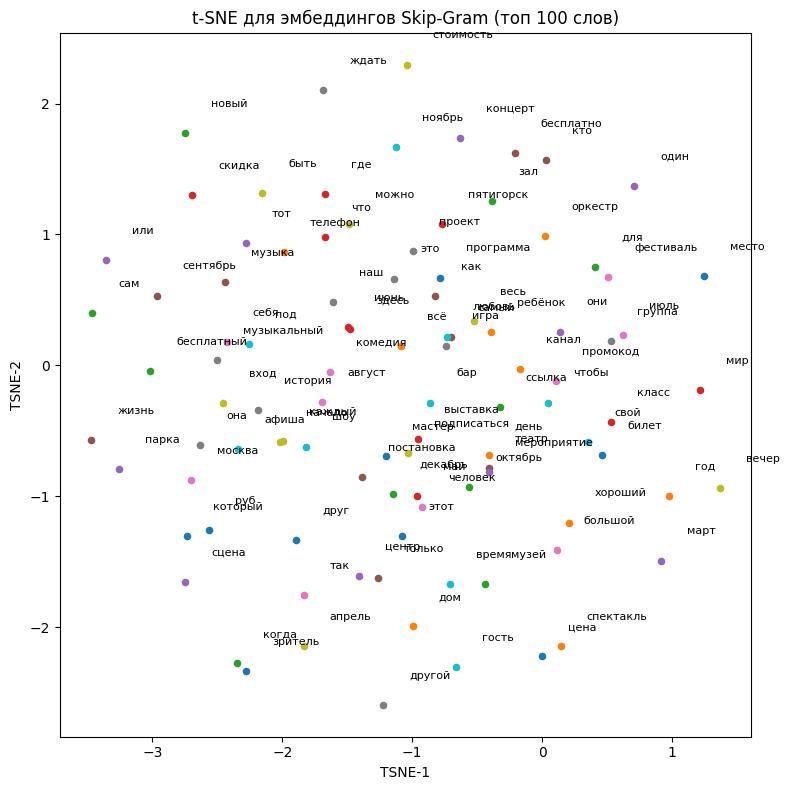

In [73]:
plt.figure(figsize=(8,8), dpi=100)
for i, w in enumerate(most_common):
    x, y = emb_2d[i]
    plt.scatter(x, y, s=20)
    plt.text(x+0.2, y+0.2, w, fontsize=8)
plt.title("t‑SNE для эмбеддингов Skip‑Gram (топ 100 слов)")
plt.xlabel("TSNE‑1")
plt.ylabel("TSNE‑2")
plt.tight_layout()
plt.show()

In [74]:
w2v = Word2Vec(sentences=df['w2v'], vector_size=100, window=4, min_count=1)

def embedding_w2v(tokens):
  vecs = [w2v.wv[w] for w in tokens if w in w2v.wv]
  return vecs

X_w2v = df['w2v'].apply(lambda row: embedding_w2v(row))
X_w2v

0        [[-0.6898185, -0.10546437, -0.025823869, -0.86...
1        [[-0.3385288, -0.24138716, -0.04612335, -0.253...
2        [[-0.36378914, 0.7570257, -0.48670918, 0.29941...
3        [[-0.14275049, 0.39053786, -0.24081197, -0.463...
4        [[-0.07439894, -0.48305205, -0.32822928, -0.72...
                               ...                        
29562    [[-0.3385288, -0.24138716, -0.04612335, -0.253...
29563    [[-0.14275049, 0.39053786, -0.24081197, -0.463...
29564    [[-0.4081722, 0.15762463, 0.6139482, -0.780439...
29565    [[0.3864032, -0.15071987, 0.08588901, -0.00579...
29566    [[-0.07439894, -0.48305205, -0.32822928, -0.72...
Name: w2v, Length: 27454, dtype: object

In [75]:
def tokenize_text(text):
    text = str(text)
    words = text.split()
    return [word for word in words if len(word) > 1]

df['ww2v'] = df['w2v'].apply(tokenize_text)

embedding_dim = 100
w2v_model = Word2Vec(
    sentences=df['ww2v'],
    vector_size=embedding_dim,
    window=5,
    min_count=2,
    workers=4,
    epochs=10
)

def vectorize(tokens):
    vectors = []
    for word in tokens:
        if word in w2v_model.wv:
            vectors.append(w2v_model.wv[word])
        elif len(word) > 3:
            for i in range(len(word)-2):
                substr = word[i:i+3]
                if substr in w2v_model.wv:
                    vectors.append(w2v_model.wv[substr])
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

X_w2v = np.stack(df['ww2v'].apply(vectorize).values)

y = np.stack(df['labels'].apply(lambda x: list(map(int, x.split())) if isinstance(x, str) else x).values).astype(np.float32)

class NeuralNet(nn.Module):
    def __init__(self, input_size, num_classes=20):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, num_classes),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.layers(x)

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32)
        )

dataset = TextDataset(X_w2v, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = NeuralNet(embedding_dim).to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

for epoch in range(20):
    model.train()
    total_loss = 0
    for X_batch, y_batch in dataloader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss/len(dataloader):.4f}")

Epoch 1, Loss: 0.3463
Epoch 2, Loss: 0.2880
Epoch 3, Loss: 0.2728
Epoch 4, Loss: 0.2629
Epoch 5, Loss: 0.2545
Epoch 6, Loss: 0.2479
Epoch 7, Loss: 0.2416
Epoch 8, Loss: 0.2357
Epoch 9, Loss: 0.2307
Epoch 10, Loss: 0.2260
Epoch 11, Loss: 0.2217
Epoch 12, Loss: 0.2178
Epoch 13, Loss: 0.2128
Epoch 14, Loss: 0.2091
Epoch 15, Loss: 0.2061
Epoch 16, Loss: 0.2022
Epoch 17, Loss: 0.1993
Epoch 18, Loss: 0.1963
Epoch 19, Loss: 0.1933
Epoch 20, Loss: 0.1905


In [76]:
def preprocess_text_for_word2vec(text, method='lemmatize'):
    # приводим весь текст к нижнему регистру 
    text = text.lower()
    
    # замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # удаляем всё, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # удаляем повторные пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # токенизация
    tokens = text.split()
    
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    
    # удаляем только очень короткие слова (длиной 1-2 символа)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

def tokenize_text(text):
    text = str(text)
    return [word for word in text.split() if len(word) > 1]

# 2. Загрузка и подготовка данных
df['processed_text'] = df['text'].apply(preprocess_text_for_word2vec)
df['tokens'] = df['processed_text'].apply(tokenize_text)

# Обучение Word2Vec модели
embedding_dim = 300 
w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=embedding_dim,
    window=window_size,
    min_count=min_count,
    workers=4,
    epochs=epochs
)

# Векторизация текстов
def vectorize(tokens):
    vectors = []
    for word in tokens:
        if word in w2v_model.wv:
            vectors.append(w2v_model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

X_w2v = np.stack(df['tokens'].apply(vectorize).values)

# 5. Подготовка меток
def parse_labels(label_str):
    return [int(x) for x in label_str.split()]

labels = np.stack(df['labels'].apply(parse_labels).values).astype(np.float32)

# Dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

# Модель 
class Model(nn.Module):
    def __init__(self, input_size, classes=20):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

dataset = MyDataset(X_w2v, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(embedding_dim, 20).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)


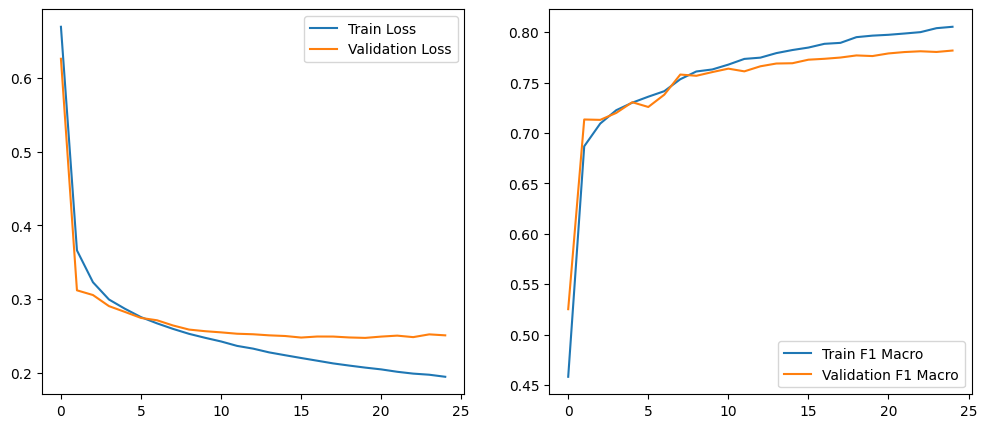

 96%|█████████▌| 24/25 [00:34<00:01,  1.43s/it]

Epoch 25/25 | LR: 0.000657 | Train Loss: 0.1946, Train F1: 0.8053 | Val Loss: 0.2509, Val F1: 0.7817
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [77]:
def calculate_f1_macro(outputs, targets, threshold=0.5):
    # Convert probabilities to binary predictions
    predicted = (outputs > threshold).float()
    
    # Calculate true positives, false positives, false negatives for each class
    tp = (predicted * targets).sum(0)
    fp = (predicted * (1 - targets)).sum(0)
    fn = ((1 - predicted) * targets).sum(0)
    
    # Calculate precision and recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return macro F1 (average across classes)
    return f1.mean().item()

# [Previous code remains the same until the training loop]

# Training setup
base_lr = lr
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []  # Changed from accuracies to F1 scores
loss_switched = False
optimizer_switched = False

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=5, verbose=True) 
best_val_f1 = 0  # Changed from best_val_acc

for epoch in tqdm(range(num_epochs)):
    model.train()
    running_loss = 0.0
    all_train_outputs = []
    all_train_targets = []

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_train_outputs.append(outputs.detach().cpu())
        all_train_targets.append(targets.detach().cpu())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_train_outputs)
    train_targets = torch.cat(all_train_targets)
    train_f1 = calculate_f1_macro(train_outputs, train_targets)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_val_outputs = []
    all_val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            all_val_outputs.append(outputs.cpu())
            all_val_targets.append(targets.cpu())

    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(all_val_outputs)
    val_targets = torch.cat(all_val_targets)
    val_f1 = calculate_f1_macro(val_outputs, val_targets)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_w2v_classification_model.pth')
        print(f'Best Val F1 Macro: {best_val_f1:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1 Macro')
    plt.plot(val_f1s, label='Validation F1 Macro')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

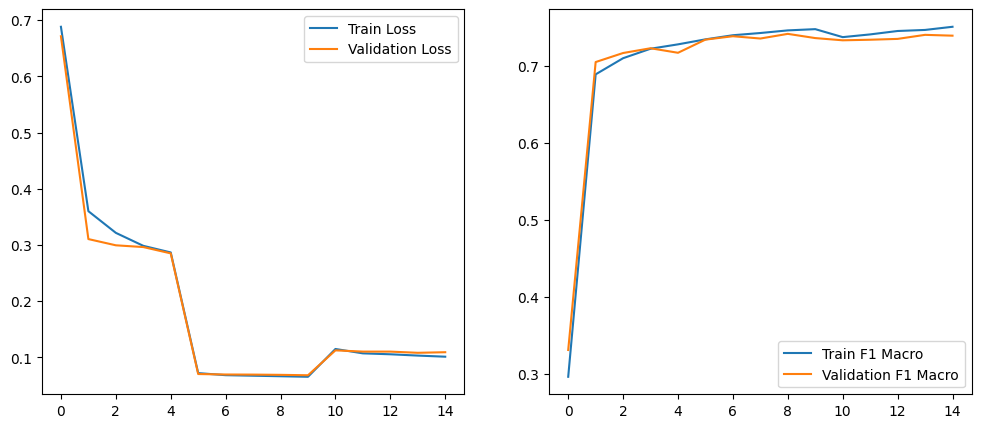

 56%|█████▌    | 14/25 [00:21<00:17,  1.56s/it]

Epoch 15/25 | LR: 0.001884 | Train Loss: 0.1012, Train F1: 0.7507 | Val Loss: 0.1092, Val F1: 0.7391
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [80]:
def calculate_f1_macro(outputs, targets, threshold=0.5):
    # Convert probabilities to binary predictions
    predicted = (outputs > threshold).float()
    
    # Calculate true positives, false positives, false negatives for each class
    tp = (predicted * targets).sum(0)
    fp = (predicted * (1 - targets)).sum(0)
    fn = ((1 - predicted) * targets).sum(0)
    
    # Calculate precision and recall for each class
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (tp + fn + 1e-10)
    
    # Calculate F1 score for each class
    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)
    
    # Return macro F1 (average across classes)
    return f1.mean().item()

class FocalLoss(_Loss):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class DiceLoss(_Loss):
    def __init__(self, smooth=1., reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# Модифицируем часть инициализации обучения
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(embedding_dim, 20).to(device)

# Создаем список доступных лоссов в порядке их применения
losses_queue = [
    nn.BCELoss(),  # Первые 5 эпох
    FocalLoss(),    # Следующие 5 эпох
    DiceLoss(),     # Затем
    lambda x, y: nn.BCELoss()(x, y) + DiceLoss()(x, y)  # Комбинация в конце
]
current_loss_idx = 0
criterion = losses_queue[current_loss_idx]
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training setup
base_lr = lr
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []  # Changed to track F1 scores
best_val_f1 = 0  # Track best F1 score instead of accuracy

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in tqdm(range(num_epochs)):
    # Переключаем лосс каждые 5 эпох
    if epoch > 0 and epoch % 5 == 0 and current_loss_idx < len(losses_queue) - 1:
        current_loss_idx += 1
        criterion = losses_queue[current_loss_idx]
        print(f"\nSwitched loss function to: {str(criterion)}\n")
    
    model.train()
    running_loss = 0.0
    all_train_outputs = []
    all_train_targets = []

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_train_outputs.append(outputs.detach().cpu())
        all_train_targets.append(targets.detach().cpu())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_train_outputs)
    train_targets = torch.cat(all_train_targets)
    train_f1 = calculate_f1_macro(train_outputs, train_targets)

    # Validation
    model.eval()
    running_val_loss = 0.0
    all_val_outputs = []
    all_val_targets = []
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            all_val_outputs.append(outputs.cpu())
            all_val_targets.append(targets.cpu())

    # Calculate validation metrics
    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(all_val_outputs)
    val_targets = torch.cat(all_val_targets)
    val_f1 = calculate_f1_macro(val_outputs, val_targets)
    
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_w2v_classification_model.pth')
        print(f'Best Val F1 Macro: {best_val_f1:.4f}')

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1 Macro')
    plt.plot(val_f1s, label='Validation F1 Macro')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Ранняя остановка
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

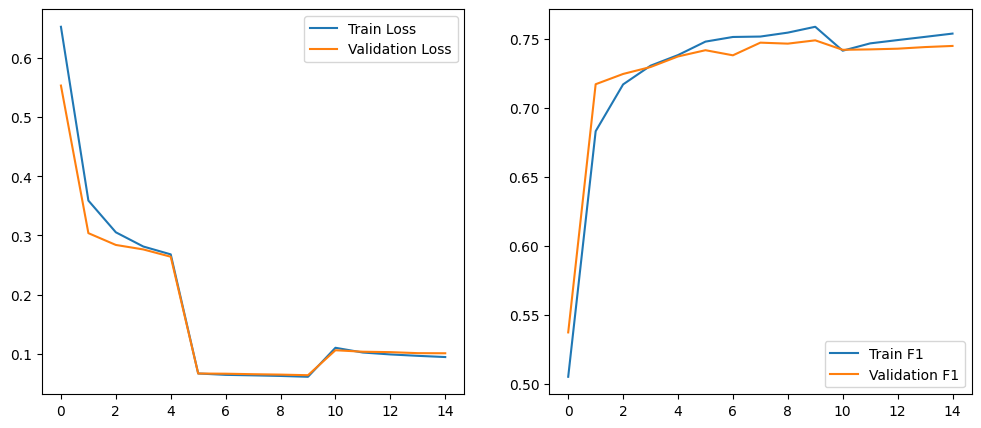

Epoch 15/25 | LR: 0.000189 | Train Loss: 0.0946, Train F1: 0.7537 | Val Loss: 0.1010, Val F1: 0.7448
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [82]:
# Инициализация инструментов для предобработки
morph = MorphAnalyzer()
stemmer = SnowballStemmer("russian")

# 1. Функции предобработки текста
def preprocess_text_for_word2vec(text, method='lemmatize'):
    text = text.lower()
    
    # замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # удаляем всё, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # удаляем повторные пробелы
    text = re.sub(r'\s+', ' ', text).strip()
    
    # токенизация
    tokens = text.split()
    
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    
    # удаляем только очень короткие слова (длиной 1-2 символа)
    tokens = [token for token in tokens if len(token) > 2]
    
    return ' '.join(tokens)

def tokenize_text(text):
    text = str(text)
    return [word for word in text.split() if len(word) > 1]

# 2. Загрузка и подготовка данных (предполагаем, что df уже загружен)
df['processed_text'] = df['text'].apply(preprocess_text_for_word2vec)
df['tokens'] = df['processed_text'].apply(tokenize_text)

# 3. Обучение Word2Vec модели
embedding_dim = 300
window_size = 5
min_count = 3
epochs = 10
batch_size = 32
lr = 0.001

w2v_model = Word2Vec(
    sentences=df['tokens'],
    vector_size=embedding_dim,
    window=window_size,
    min_count=min_count,
    workers=4,
    epochs=epochs
)

# 4. Векторизация текстов
def vectorize(tokens):
    vectors = []
    for word in tokens:
        if word in w2v_model.wv:
            vectors.append(w2v_model.wv[word])
    return np.mean(vectors, axis=0) if vectors else np.zeros(embedding_dim)

X_w2v = np.stack(df['tokens'].apply(vectorize).values)

# 5. Подготовка меток
def parse_labels(label_str):
    return [int(x) for x in label_str.split()]

labels = np.stack(df['labels'].apply(parse_labels).values).astype(np.float32)

# 6. Dataset
class MyDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx]).float(), torch.tensor(self.y[idx]).float()

# 7. Модель
class Model(nn.Module):
    def __init__(self, input_size, classes=20):
        super().__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, classes),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.nn(x)

# 8. Кастомные лоссы
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 9. Функция для расчета F1-score
def calculate_f1(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float().cpu().numpy()
    targets = targets.cpu().numpy()
    return f1_score(targets, outputs, average='macro', zero_division=0)

# 10. Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 11. Warmup scheduler
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * epoch / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

# 12. Инициализация обучения
dataset = MyDataset(X_w2v, labels)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Model(embedding_dim, 20).to(device)

# Создаем список доступных лоссов
losses_queue = [
    nn.BCELoss(),  # Первые 5 эпох
    FocalLoss(),    # Следующие 5 эпох
    DiceLoss(),     # Затем
    lambda x, y: nn.BCELoss()(x, y) + DiceLoss()(x, y)  # Комбинация в конце
]
current_loss_idx = 0
criterion = losses_queue[current_loss_idx]
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training setup
base_lr = lr
num_epochs = 25
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
best_val_f1 = 0

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    # Переключаем лосс каждые 5 эпох
    if epoch > 0 and epoch % 5 == 0 and current_loss_idx < len(losses_queue) - 1:
        current_loss_idx += 1
        criterion = losses_queue[current_loss_idx]
        print(f"\nSwitched loss function to: {str(criterion)}\n")
    
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        all_outputs.append(outputs.detach())
        all_targets.append(targets.detach())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_outputs)
    train_targets = torch.cat(all_targets)
    train_f1 = calculate_f1(train_outputs, train_targets)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_outputs = []
    val_targets = []
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            running_val_loss += loss.item() * inputs.size(0)
            val_outputs.append(outputs)
            val_targets.append(targets)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)
    val_f1 = calculate_f1(val_outputs, val_targets)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_w2v_classification_model.pth')
        print(f'Best Val F1: {best_val_f1:.4f}')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Validation F1')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

(3) встроенный эмбеддинг в нейросетевое решение на свёрточных сетях;

In [92]:
# Инициализация
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text_for_embeddings(text, method='lemmatize', use_stopwords=True):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # Удаление всего, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # Удаление повторных пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    tokens = text.split()
    
    # Обработка стоп-слов (добавлено)
    if use_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация/стемматизация (модифицировано)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]  # Для русского лучше использовать лемматизацию
    
    # Удаление коротких слов (модифицировано)
    tokens = [token for token in tokens if len(token) > 1]  # Более мягкая фильтрация
    
    return tokens  # Возвращаем список токенов вместо строки
df['inemb'] = df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize'))

100%|██████████| 27454/27454 [03:35<00:00, 127.36it/s]


In [93]:
texts = df['inemb'].tolist()
labels = df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()  # Конвертируем в float сразу

# 2. Создание словаря
word_counts = Counter()
for tokens in texts:
    word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# 3. Dataset и DataLoader
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        sequence = tokens_to_sequence(self.texts[idx])
        return (
            torch.tensor(sequence, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

full_dataset = MultilabelDataset(texts, labels, vocab)

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    labels = torch.stack(labels)
    return sequences_padded, labels

batch_size = 32
full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)

# 4. Модель CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_labels, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embedding_dim, num_filters, fs),
                nn.BatchNorm1d(num_filters),
                nn.ReLU()
            ) for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_labels)
        
    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        conved = [conv(embedded) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        return torch.sigmoid(self.fc(cat))

# Параметры модели
vocab_size = len(vocab)
embedding_dim = 128
num_labels = len(labels[0])
filter_sizes = [3, 4, 5]
num_filters = 100

model = TextCNN(vocab_size, embedding_dim, num_labels, filter_sizes, num_filters)

# 5. Обучение
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 10
for epoch in range(20):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for sequences, labels in tqdm(full_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        sequences, labels = sequences.to(device), labels.to(device)
        
        # Проверка типов
        assert labels.dtype == torch.float32, f"Метки должны быть float32, получено {labels.dtype}"
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()
    
    epoch_loss = total_loss / len(full_loader)
    epoch_acc = correct / total
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")


Epoch 1/10: 100%|██████████| 858/858 [00:11<00:00, 77.42it/s] 


Epoch 1, Loss: 0.4230, Accuracy: 0.8104


Epoch 2/10: 100%|██████████| 858/858 [00:03<00:00, 245.14it/s]


Epoch 2, Loss: 0.3206, Accuracy: 0.8561


Epoch 3/10: 100%|██████████| 858/858 [00:03<00:00, 248.69it/s]


Epoch 3, Loss: 0.2871, Accuracy: 0.8725


Epoch 4/10: 100%|██████████| 858/858 [00:03<00:00, 245.20it/s]


Epoch 4, Loss: 0.2658, Accuracy: 0.8832


Epoch 5/10: 100%|██████████| 858/858 [00:03<00:00, 246.39it/s]


Epoch 5, Loss: 0.2518, Accuracy: 0.8904


Epoch 6/10: 100%|██████████| 858/858 [00:03<00:00, 249.15it/s]

Epoch 6, Loss: 0.2407, Accuracy: 0.8956



Epoch 7/10: 100%|██████████| 858/858 [00:03<00:00, 248.74it/s]


Epoch 7, Loss: 0.2293, Accuracy: 0.9008


Epoch 8/10: 100%|██████████| 858/858 [00:03<00:00, 248.73it/s]


Epoch 8, Loss: 0.2206, Accuracy: 0.9050


Epoch 9/10: 100%|██████████| 858/858 [00:03<00:00, 249.92it/s]


Epoch 9, Loss: 0.2135, Accuracy: 0.9080


Epoch 10/10: 100%|██████████| 858/858 [00:03<00:00, 247.29it/s]


Epoch 10, Loss: 0.2061, Accuracy: 0.9121


Epoch 11/10: 100%|██████████| 858/858 [00:03<00:00, 247.82it/s]


Epoch 11, Loss: 0.2007, Accuracy: 0.9148


Epoch 12/10: 100%|██████████| 858/858 [00:03<00:00, 245.54it/s]


Epoch 12, Loss: 0.1953, Accuracy: 0.9175


Epoch 13/10: 100%|██████████| 858/858 [00:03<00:00, 246.45it/s]


Epoch 13, Loss: 0.1904, Accuracy: 0.9196


Epoch 14/10: 100%|██████████| 858/858 [00:03<00:00, 246.90it/s]


Epoch 14, Loss: 0.1864, Accuracy: 0.9215


Epoch 15/10: 100%|██████████| 858/858 [00:03<00:00, 247.45it/s]


Epoch 15, Loss: 0.1826, Accuracy: 0.9237


Epoch 16/10: 100%|██████████| 858/858 [00:03<00:00, 251.69it/s]


Epoch 16, Loss: 0.1791, Accuracy: 0.9256


Epoch 17/10: 100%|██████████| 858/858 [00:03<00:00, 248.89it/s]


Epoch 17, Loss: 0.1770, Accuracy: 0.9263


Epoch 18/10: 100%|██████████| 858/858 [00:03<00:00, 246.49it/s]


Epoch 18, Loss: 0.1732, Accuracy: 0.9283


Epoch 19/10: 100%|██████████| 858/858 [00:03<00:00, 247.68it/s]


Epoch 19, Loss: 0.1703, Accuracy: 0.9294


Epoch 20/10: 100%|██████████| 858/858 [00:03<00:00, 250.84it/s]

Epoch 20, Loss: 0.1692, Accuracy: 0.9301


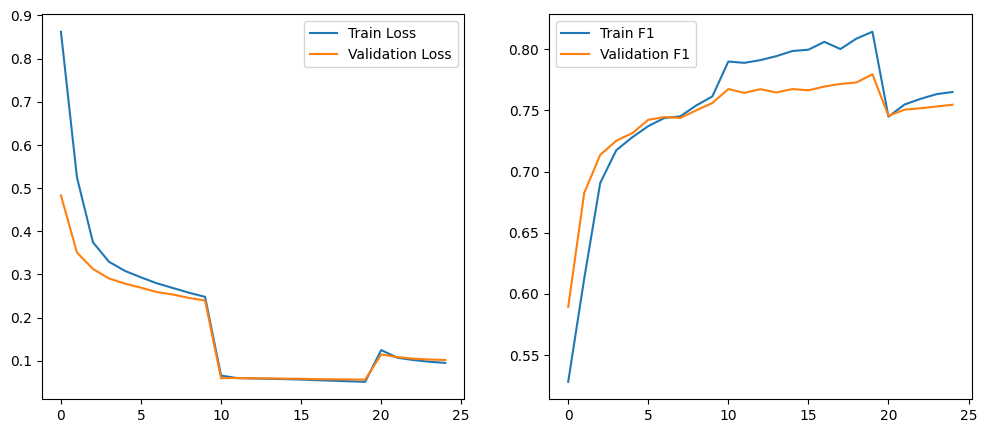

Epoch 25/50 | LR: 0.000066 | Train Loss: 0.0951, Train F1: 0.7650 | Val Loss: 0.1019, Val F1: 0.7546
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [94]:

texts = df['inemb'].tolist()
labels = df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

# 2. Создание словаря
word_counts = Counter()
for tokens in texts:
    word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# 3. Dataset и DataLoader
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.texts = texts
        self.labels = labels
        self.vocab = vocab
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        sequence = tokens_to_sequence(self.texts[idx])
        return (
            torch.tensor(sequence, dtype=torch.long),
            torch.tensor(self.labels[idx], dtype=torch.float32)
        )

def collate_fn(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    labels = torch.stack(labels)
    return sequences_padded, labels

# 4. Модель CNN
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, num_labels, filter_sizes, num_filters):
        super(TextCNN, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.convs = nn.ModuleList([
            nn.Sequential(
                nn.Conv1d(embedding_dim, num_filters, fs),
                nn.BatchNorm1d(num_filters),
                nn.ReLU()
            ) for fs in filter_sizes
        ])
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(len(filter_sizes) * num_filters, num_labels)
        
    def forward(self, x):
        embedded = self.embedding(x)  # [batch_size, seq_len, embedding_dim]
        embedded = embedded.permute(0, 2, 1)  # [batch_size, embedding_dim, seq_len]
        
        conved = [conv(embedded) for conv in self.convs]
        pooled = [torch.max(conv, dim=2)[0] for conv in conved]
        cat = torch.cat(pooled, dim=1)
        cat = self.dropout(cat)
        return torch.sigmoid(self.fc(cat))

# 5. Кастомные лоссы
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

# 6. Функция для расчета F1-score
def calculate_f1(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float().cpu().numpy()
    targets = targets.cpu().numpy()
    return f1_score(targets, outputs, average='macro', zero_division=0)

# 7. Early Stopping
class EarlyStopping:
    def __init__(self, patience=7, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 8. Warmup scheduler
def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * epoch / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

# 9. Инициализация обучения
full_dataset = MultilabelDataset(texts, labels, vocab)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

# Параметры модели
vocab_size = len(vocab)
embedding_dim = 128
num_labels = len(labels[0])
filter_sizes = [3, 4, 5]
num_filters = 100
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TextCNN(vocab_size, embedding_dim, num_labels, filter_sizes, num_filters).to(device)

# Создаем список доступных лоссов
losses_queue = [
    nn.BCELoss(),  # Первые 5 эпох
    FocalLoss(),    # Следующие 5 эпох
    DiceLoss(),     # Затем
    lambda x, y: nn.BCELoss()(x, y) + DiceLoss()(x, y)  # Комбинация в конце
]
current_loss_idx = 0
criterion = losses_queue[current_loss_idx]
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Training setup
base_lr = lr
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
best_val_f1 = 0

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    # Переключаем лосс каждые 5 эпох
    if epoch > 0 and epoch % 10 == 0 and current_loss_idx < len(losses_queue) - 1:
        current_loss_idx += 1
        criterion = losses_queue[current_loss_idx]
        print(f"\nSwitched loss function to: {str(criterion)}\n")
    
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for sequences, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        sequences, labels = sequences.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * sequences.size(0)
        all_outputs.append(outputs.detach())
        all_targets.append(labels.detach())

    # Calculate train metrics
    train_loss = running_loss / len(train_loader.dataset)
    train_outputs = torch.cat(all_outputs)
    train_targets = torch.cat(all_targets)
    train_f1 = calculate_f1(train_outputs, train_targets)

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_outputs = []
    val_targets = []
    
    with torch.no_grad():
        for sequences, labels in val_loader:
            sequences, labels = sequences.to(device), labels.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * sequences.size(0)
            val_outputs.append(outputs)
            val_targets.append(labels)

    val_loss = running_val_loss / len(val_loader.dataset)
    val_outputs = torch.cat(val_outputs)
    val_targets = torch.cat(val_targets)
    val_f1 = calculate_f1(val_outputs, val_targets)
    
    # Save best model
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_cnn_classification_model.pth')
        print(f'Best Val F1: {best_val_f1:.4f}')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Validation F1')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

**(4) встроенный эмбеддинг в нейросетевое решение на рекуррентных сетях;**

In [95]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text_for_embeddings(text, method='lemmatize', use_stopwords=True):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # Удаление всего, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # Удаление повторных пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    tokens = text.split()
    
    # Обработка стоп-слов (добавлено)
    if use_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация/стемматизация (модифицировано)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]  # Для русского лучше использовать лемматизацию
    
    # Удаление коротких слов (модифицировано)
    tokens = [token for token in tokens if len(token) > 1]  # Более мягкая фильтрация
    
    return tokens  # Возвращаем список токенов вместо строки
df['inemb'] = df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize'))

100%|██████████| 27454/27454 [03:36<00:00, 126.91it/s]


In [7]:
texts = df['inemb'].apply(eval).tolist() if isinstance(df['inemb'].iloc[0], str) else df['inemb'].tolist()
labels = df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

empty_count = sum(1 for text in texts if len(text) == 0)
if empty_count > 0:
    print("Примеры индексов пустых текстов:", [i for i, text in enumerate(texts) if len(text) == 0][:5])

word_counts = Counter()
for tokens in texts:
    if len(tokens) > 0:  
        word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Размер словаря: {len(vocab)} токенов")

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]


class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.vocab = vocab
        self.data = []
        
        for text, label in zip(texts, labels):
            if len(text) > 0: 
                self.data.append({
                    'tokens': text,
                    'label': label
                })
        print(f"После фильтрации осталось {len(self.data)} примеров")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        sequence = tokens_to_sequence(item['tokens'])
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'length': len(sequence),
            'labels': torch.tensor(item['label'], dtype=torch.float32)
        }

full_dataset = MultilabelDataset(texts, labels, vocab)

def collate_fn(batch):

    batch = [item for item in batch if item['length'] > 0]
    
    if len(batch) == 0:

        return (
            torch.zeros(0, 1, dtype=torch.long), 
            torch.zeros(0, dtype=torch.long), 
            torch.zeros(0, len(labels[0]), dtype=torch.float32))
    
    sequences = [item['sequence'] for item in batch]
    lengths = torch.tensor([item['length'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, lengths, labels

batch_size = 32
full_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    drop_last=False
)


class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_labels):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)  
        
    def forward(self, x, lengths):
    
        embedded = self.embedding(x)  
        
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        

        packed_output, (hidden, cell) = self.lstm(packed)
        

        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        return torch.sigmoid(self.fc(hidden))

# Параметры модели
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_labels = len(labels[0])

model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_labels)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
model = model.to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

num_epochs = 15
best_loss = float('inf')

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    processed_batches = 0
    
    for sequences, lengths, labels in tqdm(full_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if len(sequences) == 0:  # Пропускаем пустые батчи
            continue
            
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()
        processed_batches += 1
    
    if processed_batches > 0:
        epoch_loss = total_loss / processed_batches
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")
        
        if epoch_loss < best_loss:
            best_loss = epoch_loss
            torch.save(model.state_dict(), 'best_model.pth')
            print("Модель сохранена!")
    else:
        print(f"Epoch {epoch+1} пропущен - нет данных для обучения")


def predict(text_tokens, model, vocab, device, max_len=200):
    model.eval()
    if len(text_tokens) == 0:
        return np.zeros(num_labels)  
    
    sequence = tokens_to_sequence(text_tokens)
    length = min(len(sequence), max_len)
    padded = torch.zeros(max_len, dtype=torch.long)
    padded[:length] = torch.tensor(sequence[:length])
    
    with torch.no_grad():
        output = model(
            padded.unsqueeze(0).to(device),
            torch.tensor([length]).to(device)
        )
    return output.squeeze().cpu().numpy()

print("Обучение завершено!")

Примеры индексов пустых текстов: [281, 813, 966, 1471, 2742]
Размер словаря: 20001 токенов
После фильтрации осталось 27416 примеров
Используется устройство: cuda


Epoch 1/15: 100%|██████████| 857/857 [00:15<00:00, 54.00it/s]


Epoch 1, Loss: 0.3167, Accuracy: 0.8556
Модель сохранена!


Epoch 2/15: 100%|██████████| 857/857 [00:15<00:00, 54.90it/s]

Epoch 2, Loss: 0.2638, Accuracy: 0.8826


Модель сохранена!


Epoch 3/15: 100%|██████████| 857/857 [00:15<00:00, 54.18it/s]


Epoch 3, Loss: 0.2691, Accuracy: 0.8803


Epoch 4/15: 100%|██████████| 857/857 [00:15<00:00, 54.06it/s]


Epoch 4, Loss: 0.2454, Accuracy: 0.8921
Модель сохранена!


Epoch 5/15: 100%|██████████| 857/857 [00:15<00:00, 53.97it/s]


Epoch 5, Loss: 0.2331, Accuracy: 0.8982
Модель сохранена!


Epoch 6/15: 100%|██████████| 857/857 [00:15<00:00, 54.43it/s]


Epoch 6, Loss: 0.2264, Accuracy: 0.9015
Модель сохранена!


Epoch 7/15: 100%|██████████| 857/857 [00:15<00:00, 53.91it/s]


Epoch 7, Loss: 0.2206, Accuracy: 0.9052
Модель сохранена!


Epoch 8/15: 100%|██████████| 857/857 [00:15<00:00, 53.85it/s]


Epoch 8, Loss: 0.2185, Accuracy: 0.9060
Модель сохранена!


Epoch 9/15: 100%|██████████| 857/857 [00:15<00:00, 54.65it/s]


Epoch 9, Loss: 0.2099, Accuracy: 0.9103
Модель сохранена!


Epoch 10/15: 100%|██████████| 857/857 [00:15<00:00, 54.62it/s]


Epoch 10, Loss: 0.2056, Accuracy: 0.9126
Модель сохранена!


Epoch 11/15: 100%|██████████| 857/857 [00:15<00:00, 54.82it/s]


Epoch 11, Loss: 0.2065, Accuracy: 0.9130


Epoch 12/15: 100%|██████████| 857/857 [00:15<00:00, 54.34it/s]


Epoch 12, Loss: 0.1977, Accuracy: 0.9164
Модель сохранена!


Epoch 13/15: 100%|██████████| 857/857 [00:15<00:00, 54.74it/s]


Epoch 13, Loss: 0.1932, Accuracy: 0.9187
Модель сохранена!


Epoch 14/15: 100%|██████████| 857/857 [00:15<00:00, 54.40it/s]


Epoch 14, Loss: 0.1893, Accuracy: 0.9207
Модель сохранена!


Epoch 15/15: 100%|██████████| 857/857 [00:15<00:00, 54.32it/s]


Epoch 15, Loss: 0.1858, Accuracy: 0.9229
Модель сохранена!
Обучение завершено!


**ЗАПУСКАТЬ ЛУЧШУЮ МОДЕЛЬ ОТСЮДА!!!**

In [3]:
df = pd.read_csv("train.csv")
df = df.drop_duplicates(subset=["text", "labels"], keep='first')
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text_for_embeddings(text, method='lemmatize', use_stopwords=True):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # Удаление всего, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # Удаление повторных пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    tokens = text.split()
    
    # Обработка стоп-слов (добавлено)
    if use_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация/стемматизация (модифицировано)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]  # Для русского лучше использовать лемматизацию
    
    # Удаление коротких слов (модифицировано)
    tokens = [token for token in tokens if len(token) > 1]  # Более мягкая фильтрация
    
    return tokens  # Возвращаем список токенов вместо строки
df['inemb'] = df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize'))

100%|██████████| 27454/27454 [03:43<00:00, 122.95it/s]


In [9]:
texts = df['inemb'].apply(eval).tolist() if isinstance(df['inemb'].iloc[0], str) else df['inemb'].tolist()
labels = df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

# Проверка данных
print(f"Всего примеров: {len(texts)}")
empty_count = sum(1 for text in texts if len(text) == 0)
print(f"Пустых текстов: {empty_count}")

# 2. Создание словаря
word_counts = Counter()
for tokens in texts:
    if tokens:  # Только непустые последовательности
        word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Размер словаря: {len(vocab)}")

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# 3. Dataset и DataLoader
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.vocab = vocab
        self.samples = []
        
        for text, label in zip(texts, labels):
            if text:  # Фильтрация пустых текстов
                self.samples.append((text, label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text, label = self.samples[idx]
        sequence = tokens_to_sequence(text)
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'length': len(sequence),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

dataset = MultilabelDataset(texts, labels, vocab)

def collate_fn(batch):
    batch = [b for b in batch if b['length'] > 0]  # Фильтрация
    
    if not batch:
        return (
            torch.zeros(0, 1, dtype=torch.long),
            torch.zeros(0, dtype=torch.long),
            torch.zeros(0, len(labels[0]), dtype=torch.float32)
        )
    
    sequences = [b['sequence'] for b in batch]
    lengths = torch.tensor([b['length'] for b in batch])
    labels = torch.stack([b['labels'] for b in batch])
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, lengths, labels

batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

# 4. Модель BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        _, (hidden, _) = self.lstm(packed)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        return torch.sigmoid(self.fc(hidden))

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTMModel(
    vocab_size=len(vocab),
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_labels=len(labels[0])
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Обучение
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    processed = 0
    
    for sequences, lengths, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sequences.size(0) == 0:
            continue
            
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()
        processed += 1
    
    if processed > 0:
        avg_loss = total_loss / processed
        accuracy = correct / total
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

# 6. Функция предсказания
def predict(text_tokens, model, vocab, device, max_len=200):
    model.eval()
    if not text_tokens:
        return np.zeros(model.fc.out_features)
    
    sequence = tokens_to_sequence(text_tokens)
    length = min(len(sequence), max_len)
    padded = torch.zeros(max_len, dtype=torch.long)
    padded[:length] = torch.tensor(sequence[:length])
    
    with torch.no_grad():
        output = model(
            padded.unsqueeze(0).to(device),
            torch.tensor([length]).to(device)
        )
    return output.squeeze().cpu().numpy()

print("Обучение завершено!")

Всего примеров: 27454
Пустых текстов: 38
Размер словаря: 20001


Epoch 1/20: 100%|██████████| 857/857 [00:17<00:00, 49.07it/s]


Epoch 1 | Loss: 0.2949 | Accuracy: 0.8661


Epoch 2/20: 100%|██████████| 857/857 [00:17<00:00, 49.49it/s]


Epoch 2 | Loss: 0.2349 | Accuracy: 0.8970


Epoch 3/20: 100%|██████████| 857/857 [00:17<00:00, 50.30it/s]


Epoch 3 | Loss: 0.2056 | Accuracy: 0.9115


Epoch 4/20: 100%|██████████| 857/857 [00:17<00:00, 49.57it/s]


Epoch 4 | Loss: 0.1851 | Accuracy: 0.9217


Epoch 5/20: 100%|██████████| 857/857 [00:17<00:00, 50.39it/s]


Epoch 5 | Loss: 0.1769 | Accuracy: 0.9262


Epoch 6/20: 100%|██████████| 857/857 [00:17<00:00, 49.95it/s]


Epoch 6 | Loss: 0.1558 | Accuracy: 0.9358


Epoch 7/20: 100%|██████████| 857/857 [00:17<00:00, 49.33it/s]


Epoch 7 | Loss: 0.1357 | Accuracy: 0.9451


Epoch 8/20: 100%|██████████| 857/857 [00:17<00:00, 49.18it/s]


Epoch 8 | Loss: 0.1195 | Accuracy: 0.9522


Epoch 9/20: 100%|██████████| 857/857 [00:17<00:00, 49.39it/s]


Epoch 9 | Loss: 0.1056 | Accuracy: 0.9581


Epoch 10/20: 100%|██████████| 857/857 [00:17<00:00, 48.61it/s]


Epoch 10 | Loss: 0.0945 | Accuracy: 0.9631


Epoch 11/20: 100%|██████████| 857/857 [00:17<00:00, 49.09it/s]


Epoch 11 | Loss: 0.0835 | Accuracy: 0.9674


Epoch 12/20: 100%|██████████| 857/857 [00:17<00:00, 49.13it/s]


Epoch 12 | Loss: 0.0737 | Accuracy: 0.9716


Epoch 13/20: 100%|██████████| 857/857 [00:17<00:00, 48.24it/s]


Epoch 13 | Loss: 0.0654 | Accuracy: 0.9747


Epoch 14/20: 100%|██████████| 857/857 [00:17<00:00, 48.35it/s]


Epoch 14 | Loss: 0.0621 | Accuracy: 0.9763


Epoch 15/20: 100%|██████████| 857/857 [00:17<00:00, 48.81it/s]


Epoch 15 | Loss: 0.0536 | Accuracy: 0.9796


Epoch 16/20: 100%|██████████| 857/857 [00:16<00:00, 52.01it/s]


Epoch 16 | Loss: 0.0495 | Accuracy: 0.9815


Epoch 17/20: 100%|██████████| 857/857 [00:16<00:00, 51.10it/s]


Epoch 17 | Loss: 0.0454 | Accuracy: 0.9831


Epoch 18/20: 100%|██████████| 857/857 [00:16<00:00, 51.17it/s]


Epoch 18 | Loss: 0.0427 | Accuracy: 0.9843


Epoch 19/20: 100%|██████████| 857/857 [00:16<00:00, 52.00it/s]


Epoch 19 | Loss: 0.0402 | Accuracy: 0.9852


Epoch 20/20: 100%|██████████| 857/857 [00:16<00:00, 51.75it/s]

Epoch 20 | Loss: 0.0379 | Accuracy: 0.9860
Обучение завершено!


In [10]:
test_df = pd.read_csv('test.csv')
test_texts = test_df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize')).tolist() 
test_ids = test_df['id'].tolist()

def predict_safe_batch(texts_list, model, vocab, device, max_len=200):
    sequences = []
    lengths = []
    valid_indices = []  # Для отслеживания корректных примеров
    
    for i, tokens in enumerate(texts_list):
        if len(tokens) == 0:  # Пропускаем пустые тексты
            continue
            
        seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        length = min(len(seq), max_len)
        padded = torch.zeros(max_len, dtype=torch.long)
        padded[:length] = torch.tensor(seq[:length])
        sequences.append(padded)
        lengths.append(length)
        valid_indices.append(i)
    
    if not sequences:  # Если все тексты в батче пустые
        return None, valid_indices
    
    sequences_tensor = torch.stack(sequences).to(device)
    lengths_tensor = torch.tensor(lengths).to(device)
    
    with torch.no_grad():
        outputs = model(sequences_tensor, lengths_tensor)
    return outputs.cpu().numpy(), valid_indices

# 3. Предсказание для всех данных с обработкой пустых текстов
batch_size = 32
all_predictions = np.zeros((len(test_texts), model.fc.out_features))  # Инициализация нулями

for i in tqdm(range(0, len(test_texts), batch_size), desc="Обработка"):
    batch_texts = test_texts[i:i+batch_size]
    batch_preds, valid_indices = predict_safe_batch(batch_texts, model, vocab, device)
    
    if batch_preds is not None:
        # Заполняем только валидные предсказания
        for pred_idx, original_idx in enumerate(valid_indices):
            all_predictions[i + original_idx] = batch_preds[pred_idx]

# 4. Преобразование в бинарный формат
binary_predictions = (all_predictions > 0.5).astype(int)

# 5. Сохранение результатов
results = pd.DataFrame({
    'id': test_ids,
    'labels': [' '.join(map(str, pred)) for pred in binary_predictions]
})

results.to_csv('test_predictions_hope.csv', index=False)
print("Результаты сохранены в test_predictions.csv")
print(f"Пример предсказаний:\n{results.head(3)}")

Обработка: 100%|██████████| 231/231 [00:01<00:00, 147.97it/s]


Результаты сохранены в test_predictions.csv
Пример предсказаний:
      id                                   labels
0  29568  1 0 0 0 1 0 0 1 1 1 0 1 1 1 0 1 1 1 1 0
1  29569  1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 1 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0


ЛУЧШАЯ МОДЕЛЬ !!!! вверх

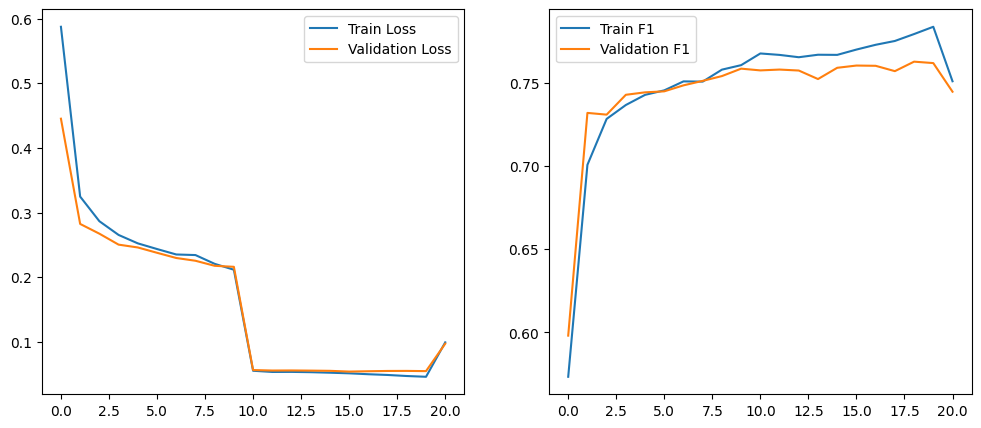

Epoch 21/50 | LR: 0.000101 | Train Loss: 0.0991, Train F1: 0.7508 | Val Loss: 0.0970, Val F1: 0.7445
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [101]:
texts = df['inemb'].apply(eval).tolist() if isinstance(df['inemb'].iloc[0], str) else df['inemb'].tolist()
labels = df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

empty_count = sum(1 for text in texts if len(text) == 0)
if empty_count > 0:
    print(f"Найдено {empty_count} пустых текстов. Они будут отфильтрованы.")

word_counts = Counter()
for tokens in texts:
    if len(tokens) > 0:
        word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Размер словаря: {len(vocab)} токенов")

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.vocab = vocab
        self.data = []
        
        for text, label in zip(texts, labels):
            if len(text) > 0:
                self.data.append({
                    'tokens': text,
                    'label': label
                })
        print(f"После фильтрации осталось {len(self.data)} примеров")
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        item = self.data[idx]
        sequence = tokens_to_sequence(item['tokens'])
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'length': len(sequence),
            'labels': torch.tensor(item['label'], dtype=torch.float32)
        }

def collate_fn(batch):
    batch = [item for item in batch if item['length'] > 0]
    
    if len(batch) == 0:
        return (
            torch.zeros(0, 1, dtype=torch.long), 
            torch.zeros(0, dtype=torch.long), 
            torch.zeros(0, len(labels[0]), dtype=torch.float32))
    
    sequences = [item['sequence'] for item in batch]
    lengths = torch.tensor([item['length'] for item in batch])
    labels = torch.stack([item['labels'] for item in batch])
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, lengths, labels

# 4. Модель BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_labels):
        super(BiLSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        packed_output, (hidden, cell) = self.lstm(packed)
        
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        return torch.sigmoid(self.fc(hidden))

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        BCE_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        
        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        else:
            return loss

def calculate_f1(outputs, targets, threshold=0.5):
    outputs = (outputs > threshold).float().cpu().numpy()
    targets = targets.cpu().numpy()
    return f1_score(targets, outputs, average='macro', zero_division=0)

class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

def warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5):
    if epoch < warmup_epochs:
        lr = warmup_lr_start + (base_lr - warmup_lr_start) * epoch / warmup_epochs
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr
    return optimizer

full_dataset = MultilabelDataset(texts, labels, vocab)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True, 
    collate_fn=collate_fn,
    drop_last=False
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False, 
    collate_fn=collate_fn,
    drop_last=False
)

# Параметры модели
vocab_size = len(vocab)
embedding_dim = 128
hidden_dim = 256
num_layers = 2
num_labels = len(labels[0])
lr = 0.001

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Используется устройство: {device}")
model = BiLSTMModel(vocab_size, embedding_dim, hidden_dim, num_layers, num_labels).to(device)


losses_queue = [
    nn.BCELoss(),  # Первые 5 эпох
    FocalLoss(),    # Следующие 5 эпох
    DiceLoss(),     # Затем
    lambda x, y: nn.BCELoss()(x, y) + DiceLoss()(x, y)  # Комбинация в конце
]
current_loss_idx = 0
criterion = losses_queue[current_loss_idx]
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

# Training setup
base_lr = lr
num_epochs = 50
warmup_epochs = 3
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
best_val_f1 = 0

scheduler_exp = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
early_stopping = EarlyStopping(patience=5, verbose=True)

for epoch in range(num_epochs):
    # Переключаем лосс каждые 5 эпох
    if epoch > 0 and epoch % 10 == 0 and current_loss_idx < len(losses_queue) - 1:
        current_loss_idx += 1
        criterion = losses_queue[current_loss_idx]
        print(f"\nSwitched loss function to: {str(criterion)}\n")
    
    model.train()
    running_loss = 0.0
    all_outputs = []
    all_targets = []
    processed_batches = 0

    if epoch < warmup_epochs:
        optimizer = warmup_lr_scheduler(optimizer, epoch, warmup_epochs, base_lr, warmup_lr_start=1e-5)
    else:
        scheduler_exp.step()

    for sequences, lengths, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if len(sequences) == 0:
            continue
            
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * sequences.size(0)
        all_outputs.append(outputs.detach())
        all_targets.append(labels.detach())
        processed_batches += 1

    # Calculate train metrics
    if processed_batches > 0:
        train_loss = running_loss / (processed_batches * batch_size)
        train_outputs = torch.cat(all_outputs)
        train_targets = torch.cat(all_targets)
        train_f1 = calculate_f1(train_outputs, train_targets)
    else:
        train_loss = 0
        train_f1 = 0

    # Validation
    model.eval()
    running_val_loss = 0.0
    val_outputs = []
    val_targets = []
    val_processed_batches = 0
    
    with torch.no_grad():
        for sequences, lengths, labels in val_loader:
            if len(sequences) == 0:
                continue
                
            sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
            outputs = model(sequences, lengths)
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * sequences.size(0)
            val_outputs.append(outputs)
            val_targets.append(labels)
            val_processed_batches += 1

    if val_processed_batches > 0:
        val_loss = running_val_loss / (val_processed_batches * batch_size)
        val_outputs = torch.cat(val_outputs)
        val_targets = torch.cat(val_targets)
        val_f1 = calculate_f1(val_outputs, val_targets)
    else:
        val_loss = 0
        val_f1 = 0
    
    # Save best model
    if val_f1 > best_val_f1 and val_processed_batches > 0:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_bilstm_model.pth')
        print(f'Best Val F1: {best_val_f1:.4f}')

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)

    # Plotting
    clear_output(wait=True)
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Validation F1')
    plt.legend()
    plt.show()

    print(f"Epoch {epoch+1}/{num_epochs} | LR: {optimizer.param_groups[0]['lr']:.6f} | "
          f"Train Loss: {train_loss:.4f}, Train F1: {train_f1:.4f} | "
          f"Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}")

    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

# Функция для предсказания
def predict(text_tokens, model, vocab, device, max_len=200):
    model.eval()
    if len(text_tokens) == 0:
        return np.zeros(num_labels)
    
    sequence = tokens_to_sequence(text_tokens)
    length = min(len(sequence), max_len)
    padded = torch.zeros(max_len, dtype=torch.long)
    padded[:length] = torch.tensor(sequence[:length])
    
    with torch.no_grad():
        output = model(
            padded.unsqueeze(0).to(device),
            torch.tensor([length]).to(device)
        )
    return output.squeeze().cpu().numpy()

**(5) эмбеддер + решение на bert-like моделях (любой вид)**

In [72]:
def preprocess_text_for_embeddings(text, method='lemmatize', use_stopwords=True):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # Удаление всего, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # Удаление повторных пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    tokens = text.split()
    
    # Обработка стоп-слов (добавлено)
    if use_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация/стемматизация (модифицировано)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]  # Для русского лучше использовать лемматизацию
    
    # Удаление коротких слов (модифицировано)
    tokens = [token for token in tokens if len(token) > 1]  # Более мягкая фильтрация
    
    return tokens  # Возвращаем список токенов вместо строки
df['bert'] = df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize')).tolist()

100%|██████████| 27454/27454 [03:41<00:00, 123.72it/s]
/tmp/ipykernel_4798/1119129928.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['bert'] = df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize')).tolist()


In [73]:

os.environ["TORCH_DISABLE_FLEX_ATTENTION"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Подготовка данных
def load_data(df):
    # Преобразование меток из строк в numpy array
    df['labels'] = df['labels'].apply(
        lambda x: list(map(float, x.split())) if isinstance(x, str) else x
    )
    # Проверка формата меток
    try:
        labels = np.stack(df['labels'].values).astype(np.float32)
    except Exception as e:
        raise ValueError(f"Ошибка преобразования меток: {e}. Проверьте формат данных.")
    
    return df['bert'].values, labels

# Dataset класс
class RussianMultilabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        assert len(self.texts) == len(self.labels), "Количество текстов и меток не совпадает"
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

# Модель
class BertMultilabelClassifier(nn.Module):
    def __init__(self, bert_model, num_labels):
        super().__init__()
        self.bert = bert_model
        for param in self.bert.parameters():
            param.requires_grad = False
        self.classifier = nn.Sequential(
            nn.Linear(768, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, num_labels)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_token = outputs.last_hidden_state[:, 0, :]
        return torch.sigmoid(self.classifier(cls_token))

texts, labels = load_data(df)

# Загрузка модели
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased').to(device)

# Создание Dataset и DataLoader
dataset = RussianMultilabelDataset(texts, labels, tokenizer)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

# Инициализация модели
num_labels = labels.shape[1]
model = BertMultilabelClassifier(bert_model, num_labels).to(device)

# Критерий и оптимизатор
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=2e-5)

# Цикл обучения
for epoch in range(10):
    print(f'\nEpoch {epoch + 1}')
    model.train()
    total_loss = 0.0
    
    for batch in tqdm(dataloader, desc='Training'):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    avg_loss = total_loss / len(dataloader)
    print(f'Training Loss: {avg_loss:.4f}')

/tmp/ipykernel_4798/1896111003.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['labels'] = df['labels'].apply(
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.wei


Epoch 1


Training: 100%|██████████| 858/858 [01:39<00:00,  8.61it/s]


Training Loss: 0.4811

Epoch 2


Training: 100%|██████████| 858/858 [01:41<00:00,  8.46it/s]


Training Loss: 0.3870

Epoch 3


Training: 100%|██████████| 858/858 [01:41<00:00,  8.42it/s]


Training Loss: 0.3741

Epoch 4


Training: 100%|██████████| 858/858 [01:42<00:00,  8.41it/s]


Training Loss: 0.3686

Epoch 5


Training: 100%|██████████| 858/858 [01:41<00:00,  8.42it/s]


Training Loss: 0.3646

Epoch 6


Training: 100%|██████████| 858/858 [01:42<00:00,  8.40it/s]


Training Loss: 0.3616

Epoch 7


Training: 100%|██████████| 858/858 [01:42<00:00,  8.40it/s]


Training Loss: 0.3593

Epoch 8


Training: 100%|██████████| 858/858 [01:42<00:00,  8.39it/s]


Training Loss: 0.3572

Epoch 9


Training: 100%|██████████| 858/858 [01:42<00:00,  8.39it/s]


Training Loss: 0.3555

Epoch 10


Training: 100%|██████████| 858/858 [01:42<00:00,  8.40it/s]

Training Loss: 0.3541


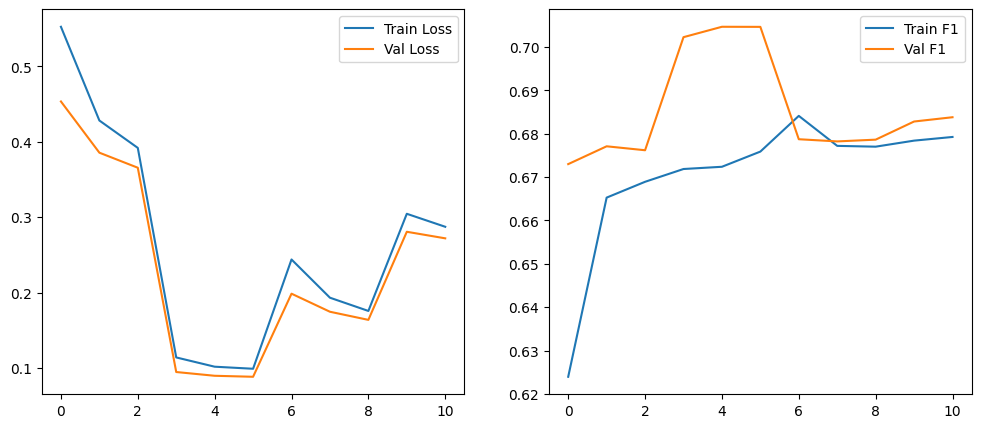

Epoch 11/15:
Train Loss: 0.2873 | Val Loss: 0.2720
Train F1: 0.6793 | Val F1: 0.6838
Current Loss: <function <lambda> at 0x7fdea6a3d1b0>
LR: 1.00e-05
EarlyStopping counter: 5 out of 5
Early stopping triggered!
Training completed!


In [74]:

os.environ["TORCH_DISABLE_FLEX_ATTENTION"] = "1"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 1. Кастомные лоссы
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        bce_loss = nn.BCELoss(reduction='none')(inputs, targets)
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        
        if self.reduction == 'mean':
            return torch.mean(focal_loss)
        elif self.reduction == 'sum':
            return torch.sum(focal_loss)
        return focal_loss

class DiceLoss(nn.Module):
    def __init__(self, smooth=1., reduction='mean'):
        super().__init__()
        self.smooth = smooth
        self.reduction = reduction

    def forward(self, inputs, targets):
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        loss = 1 - dice
        
        if self.reduction == 'mean':
            return loss.mean()
        elif self.reduction == 'sum':
            return loss.sum()
        return loss

# 2. Функции для расчета метрик
def calculate_metrics(outputs, labels, threshold=0.5):
    preds = (outputs > threshold).float()
    accuracy = (preds == labels).float().mean()
    f1 = f1_score(labels.cpu().numpy(), preds.cpu().numpy(), average='macro', zero_division=0)
    return accuracy.item(), f1

# 3. Early Stopping
class EarlyStopping:
    def __init__(self, patience=5, verbose=True):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

# 4. Подготовка данных
def load_data(df):
    df['labels'] = df['labels'].apply(
        lambda x: list(map(float, x.split())) if isinstance(x, str) else x
    )
    try:
        labels = np.stack(df['labels'].values).astype(np.float32)
    except Exception as e:
        raise ValueError(f"Ошибка преобразования меток: {e}")
    
    return df['bert'].values, labels

# 5. Dataset класс
class RussianMultilabelDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        assert len(self.texts) == len(self.labels), "Количество текстов и меток не совпадает"
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )
        
        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

# 6. Модель с улучшенной архитектурой
class BertMultilabelClassifier(nn.Module):
    def __init__(self, bert_model, num_labels):
        super().__init__()
        self.bert = bert_model
        for param in self.bert.parameters():
            param.requires_grad = False  # Замораживаем BERT
        
        # Улучшенный классификатор
        self.classifier = nn.Sequential(
            nn.Linear(768, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, num_labels)
        )
    
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
        )
        cls_token = outputs.last_hidden_state[:, 0, :]
        return torch.sigmoid(self.classifier(cls_token))

# 7. Инициализация
texts, labels = load_data(df)
tokenizer = AutoTokenizer.from_pretrained('DeepPavlov/rubert-base-cased')
bert_model = AutoModel.from_pretrained('DeepPavlov/rubert-base-cased').to(device)
num_labels = labels.shape[1]

# Разделение на train/val
dataset = RussianMultilabelDataset(texts, labels, tokenizer)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

model = BertMultilabelClassifier(bert_model, num_labels).to(device)

# 8. Настройка обучения
losses_queue = [
    nn.BCELoss(),  # Первые 3 эпохи
    FocalLoss(),    # Следующие 3 эпохи
    DiceLoss(),     # Затем
    lambda x, y: 0.5*nn.BCELoss()(x, y) + 0.5*DiceLoss()(x, y)  # Комбинация
]
current_loss_idx = 0
criterion = losses_queue[current_loss_idx]

optimizer = optim.AdamW(model.parameters(), lr=2e-5, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, factor=0.5)
early_stopping = EarlyStopping(patience=5, verbose=True)

# 9. Цикл обучения
num_epochs = 15
train_losses, val_losses = [], []
train_f1s, val_f1s = [], []
best_val_f1 = 0

for epoch in range(num_epochs):
    # Переключение лосса каждые 3 эпохи
    if epoch > 0 and epoch % 3 == 0 and current_loss_idx < len(losses_queue)-1:
        current_loss_idx += 1
        criterion = losses_queue[current_loss_idx]
        print(f"\nПереключен лосс на: {str(criterion)}\n")
    
    model.train()
    epoch_train_loss = 0
    all_outputs, all_labels = [], []
    
    for batch in tqdm(train_loader, desc=f'Training Epoch {epoch+1}'):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        
        epoch_train_loss += loss.item()
        all_outputs.append(outputs.detach())
        all_labels.append(labels.detach())
    
    # Валидация
    model.eval()
    epoch_val_loss = 0
    val_outputs, val_labels = [], []
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc='Validating'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            
            epoch_val_loss += loss.item()
            val_outputs.append(outputs)
            val_labels.append(labels)
    
    # Расчет метрик
    train_outputs = torch.cat(all_outputs)
    train_labels = torch.cat(all_labels)
    train_acc, train_f1 = calculate_metrics(train_outputs, train_labels)
    
    val_outputs = torch.cat(val_outputs)
    val_labels = torch.cat(val_labels)
    val_acc, val_f1 = calculate_metrics(val_outputs, val_labels)
    
    # Сохранение метрик
    train_loss = epoch_train_loss / len(train_loader)
    val_loss = epoch_val_loss / len(val_loader)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_f1s.append(train_f1)
    val_f1s.append(val_f1)
    
    scheduler.step(val_loss)
    
    # Визуализация
    clear_output()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(train_f1s, label='Train F1')
    plt.plot(val_f1s, label='Val F1')
    plt.legend()
    plt.show()
    
    print(f"Epoch {epoch+1}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    print(f"Train F1: {train_f1:.4f} | Val F1: {val_f1:.4f}")
    print(f"Current Loss: {str(criterion)}")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")
    
    # Сохранение лучшей модели
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        torch.save(model.state_dict(), 'best_bert_model.pt')
        print("Model saved with best F1!")
    
    # Early stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered!")
        break

print("Training completed!")

In [85]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_name = 'DeepPavlov/rubert-base-cased'
batch_size = 32
learning_rate = 2e-5
epochs = 5
max_length = 128

# Загрузка и подготовка данных
df_5 = pd.read_csv('train.csv')  # Требуются колонки 'text' и 'labels'
texts = df_5['text'].tolist()
labels = np.stack(df_5['labels'].apply(lambda x: list(map(float, x.split()))).values)

# Токенизатор
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Dataset
class TextClassifierDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        encoding = tokenizer(
            str(self.texts[idx]),
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.FloatTensor(self.labels[idx])
        }

# Модель
class BertForMultiLabel(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.classifier = nn.Linear(768, num_classes)
        
    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask)
        return torch.sigmoid(self.classifier(outputs.last_hidden_state[:, 0]))

# Инициализация
dataset = TextClassifierDataset(texts, labels)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
model = BertForMultiLabel(num_classes=labels.shape[1]).to(device)
optimizer = AdamW(model.parameters(), lr=learning_rate)
criterion = nn.BCELoss()

# Обучение
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for batch in tqdm(dataloader, desc=f'Epoch {epoch+1}'):
        optimizer.zero_grad()
        
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        targets = batch['labels'].to(device)
        
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
    
    print(f'Epoch {epoch+1}, Loss: {epoch_loss/len(dataloader):.4f}')

2025-05-16 18:26:29.857022: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/jupyter/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initi

Epoch 1, Loss: 0.2475


Epoch 2: 100%|██████████| 924/924 [05:12<00:00,  2.95it/s]


Epoch 2, Loss: 0.1597


Epoch 3: 100%|██████████| 924/924 [05:12<00:00,  2.95it/s]


Epoch 3, Loss: 0.1208


Epoch 4: 100%|██████████| 924/924 [05:13<00:00,  2.95it/s]


Epoch 4, Loss: 0.0927


Epoch 5: 100%|██████████| 924/924 [05:13<00:00,  2.95it/s]

Epoch 5, Loss: 0.0723


**ГЕНЕРАЦИЯ**

In [15]:
def analyze_label_distribution(df):
    label_counts = Counter(df['labels'])
    total = sum(label_counts.values())
    dist = {label: count/total for label, count in label_counts.items()}
    print("Распределение меток в исходных данных:")
    for label, prob in dist.items():
        print(f"{label}: {prob:.2%}")
    return dist

In [16]:
cls_p = {}
for idx in range(20):
  total_sum = sum(list(plots.values()))
  cls_p[idx] = plots[idx] / total_sum
cls_p
text_inputs = []
for cls, p in cls_p.items():
  text_inputs.append(f"Вероятность класса {cls} = {p}")
text_inputs = "\n".join(text_inputs)
text_inputs

'Вероятность класса 0 = 0.051017645587232395\nВероятность класса 1 = 0.06102446530340883\nВероятность класса 2 = 0.004715542441595471\nВероятность класса 3 = 0.005664819517410838\nВероятность класса 4 = 0.05780651882618634\nВероятность класса 5 = 0.0003324183261880528\nВероятность класса 6 = 0.0006716906384830758\nВероятность класса 7 = 0.07257685888670704\nВероятность класса 8 = 0.07382085736512212\nВероятность класса 9 = 0.06570916480752294\nВероятность класса 10 = 0.04062014866295866\nВероятность класса 11 = 0.05913619213093855\nВероятность класса 12 = 0.07447884003139126\nВероятность класса 13 = 0.07315602071274602\nВероятность класса 14 = 0.07164814376921258\nВероятность класса 15 = 0.04713143546458031\nВероятность класса 16 = 0.06955082402047971\nВероятность класса 17 = 0.0752944643781207\nВероятность класса 18 = 0.0776179656683836\nВероятность класса 19 = 0.018025983461331524'

In [12]:
def preprocess_text(text, method='lemmatize'):
    # приводим весь текст к нижнему регистру 
    text = text.lower()
    # замена всего некиррилического на пробелы
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
# Email
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
# URL
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    text = re.sub(r'[^а-яё\s]', ' ', text)
    # могли появиться повторные пробелы - удаляем их
    text = re.sub(r'\s+', ' ', text).strip()
    # токенизация (разбиение на слова)
    tokens = text.split()
    # лемматизация или стемматизация
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [stemmer.stem(token) for token in tokens]
    # удаление коротких слов и стоп слов
    tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
    return ' '.join(tokens)
df['processed_text'] = df['text'].progress_apply(lambda x: preprocess_text(x, method='lemmatize'))

100%|██████████| 27454/27454 [06:36<00:00, 69.25it/s]


In [ ]:
df['labels'] = df['labels'].apply(lambda x: [float(num) for num in x.split()])

In [51]:
from tqdm.auto import tqdm  # Исправленный импорт

In [55]:
# 1. Проверка входных данных
def error_exit(message):
    """Завершает программу с сообщением об ошибке"""
    print(f"ОШИБКА: {message}", file=sys.stderr)
    sys.exit(1)
def debug_checkpoint(message):
    """Выводит отладочное сообщение"""
    print(f"[DEBUG] {message}")

# def validate_input_data(df):
#     if not isinstance(df, pd.DataFrame):
#         error_exit("Входные данные должны быть pandas DataFrame")
    
#     required_columns = {'cleaned_text', 'labels'}
#     if not required_columns.issubset(df.columns):
#         error_exit(f"Не хватает колонок: {required_columns - set(df.columns)}")
    
#     # Проверка формата меток
#     sample_labels = df['labels'].iloc[0]
#     if not (isinstance(sample_labels, (list, np.ndarray)) and len(sample_labels) != 20):
#         error_exit("Метки должны быть списком/массивом из 20 элементов (1.0 или 0.0)")
    
#     # Проверка значений меток
#     for label in sample_labels:
#         if label not in [0.0, 1.0]:
#             error_exit("Метки должны содержать только 0.0 или 1.0")
    
#     debug_checkpoint("Формат входных данных")
#     return True
def validate_input_data(df):
    if not isinstance(df, pd.DataFrame):
        error_exit("Входные данные должны быть pandas DataFrame")
    
    required_columns = {'cleaned_text', 'labels'}
    if not required_columns.issubset(df.columns):
        error_exit(f"Не хватает колонок: {required_columns - set(df.columns)}")
    
    # Преобразование меток в унифицированный формат
    try:
        if isinstance(df['labels'].iloc[0], str):
            df['labels'] = df['labels'].apply(lambda x: [float(i) for i in x.split()])
        elif isinstance(df['labels'].iloc[0], (list, np.ndarray)):
            df['labels'] = df['labels'].apply(lambda x: [float(i) for i in x])
        else:
            error_exit(f"Неизвестный формат меток: {type(df['labels'].iloc[0])}")
    except Exception as e:
        error_exit(f"Ошибка преобразования меток: {str(e)}")
    
    # Проверка формата меток
    sample_labels = df['labels'].iloc[0]
    if not isinstance(sample_labels, (list, np.ndarray)) or len(sample_labels) != 20:
        error_exit(f"Метки должны быть списком/массивом из 20 элементов. Получено: {type(sample_labels)}, длина {len(sample_labels)}")
    
    # Проверка значений меток
    for label in sample_labels:
        if label not in [0.0, 1.0]:
            error_exit(f"Метки должны содержать только 0.0 или 1.0. Найдено: {label}")
    
    debug_checkpoint("Формат входных данных")
    return True
# 2. Анализ распределения меток (адаптировано под float)
def analyze_label_distribution(df):
    try:
        label_counts = defaultdict(int)
        label_cooccurrence = defaultdict(int)  # Для анализа совместного появления
        
        for labels in df['labels']:
            active_labels = [i for i, val in enumerate(labels) if val == 1.0]
            
            # Считаем частоту каждой метки
            for idx in active_labels:
                label_counts[idx] += 1
            
            # Считаем совместное появление (для проверки корреляции)
            for i in range(len(active_labels)):
                for j in range(i+1, len(active_labels)):
                    pair = tuple(sorted((active_labels[i], active_labels[j])))
                    label_cooccurrence[pair] += 1
        
        total_samples = len(df)
        if total_samples == 0:
            error_exit("Датафрейм не содержит данных")
        
        dist = {label: count/total_samples for label, count in label_counts.items()}
        
        # Формируем текстовое представление
        print("\nРаспределение меток (доля текстов с меткой):")
        for cls in sorted(dist.keys()):
            print(f"Класс {cls}: {dist[cls]:.2%} ({label_counts[cls]} текстов)")
        
        # Топ-5 самых частых пар меток
        top_pairs = sorted(label_cooccurrence.items(), key=lambda x: x[1], reverse=True)[:5]
        print("\nТоп-5 комбинаций меток:")
        for pair, count in top_pairs:
            print(f"Метки {pair}: {count} текстов ({count/total_samples:.1%})")
        
        debug_checkpoint("Анализ распределения меток")
        return dist
    
    except Exception as e:
        error_exit(f"Ошибка анализа меток: {str(e)}")

# 3. Генерация промпта с учетом float-меток
def create_prompt(text, labels):
    active_labels = [i for i, val in enumerate(labels) if val == 1.0]
    prompt = (f"Текст: {text}\n"
              f"Активные метки: {active_labels}\n"
              "Сгенерируй другой текст с такими же метками, сохраняя стиль и содержание:\n")
    return prompt

# 4. Основной процесс генерации
def generate_synthetic_data(df, num_samples=1000):
    print("\n=== НАЧАЛО ГЕНЕРАЦИИ ДАННЫХ ===")
    
    # Проверка входных данных
    if not validate_input_data(df):
        return None
    
    # Анализ распределения
    label_dist = analyze_label_distribution(df)

    try:
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        print(f"Используемое устройство: {device}")
        
        model_name = 'sberbank-ai/rugpt3large_based_on_gpt2'
        print(f"Загрузка модели {model_name}...")
        
        tokenizer = GPT2Tokenizer.from_pretrained(model_name)
        model = GPT2LMHeadModel.from_pretrained(model_name).to(device)
        tokenizer.pad_token = tokenizer.eos_token
        
        debug_checkpoint("Загрузка модели")
    except Exception as e:
        error_exit(f"Ошибка загрузки модели: {str(e)}")
    
    # Подготовка
    synthetic_data = []
    stats = {
        'success': 0,
        'empty_text': 0,
        'duplicate': 0,
        'too_short': 0,
        'generation_errors': 0,
        'label_dist': defaultdict(int)
    }
    
    # Прогресс-бар с подробным описанием
    with tqdm(total=num_samples, desc="Генерация данных") as pbar:
        while stats['success'] < num_samples:
            try:
                # Выбор случайного примера с учетом распределения меток
                example = df.sample(1).iloc[0]
                active_labels = [i for i, val in enumerate(example['labels']) if val == 1.0]
                
                if not active_labels:
                    continue
                
                # Формирование промпта
                prompt = create_prompt(example['cleaned_text'], example['labels'])
                
                # Генерация текста
                inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=512).to(device)
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=100,
                    temperature=0.5,
                    top_k=50,
                    top_p=0.9,
                    do_sample=True,
                    num_return_sequences=1,
                    pad_token_id=tokenizer.eos_token_id,
                    no_repeat_ngram_size=2
                )
                generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)[len(prompt):].strip()
                
                # Проверки качества
                if not generated_text:
                    stats['empty_text'] += 1
                    continue
                
                if len(generated_text.split()) < 5:  # Увеличил минимальную длину
                    stats['too_short'] += 1
                    continue
                
                if generated_text == example['cleaned_text']:
                    stats['duplicate'] += 1
                    continue
                
                # Проверка уникальности
                if any(generated_text in data['text'] for data in synthetic_data):
                    stats['duplicate'] += 1
                    continue
                
                # Успешная генерация
                synthetic_data.append({
                    'text': generated_text,
                    'labels': example['labels'],  # Сохраняем оригинальные метки
                    'source_text': example['cleaned_text'][:100] + "...",
                    'active_labels': active_labels
                })
                
                # Обновляем статистику
                for idx in active_labels:
                    stats['label_dist'][idx] += 1
                stats['success'] += 1
                pbar.update(1)
                
            except torch.cuda.OutOfMemoryError:
                print("\n Недостаточно памяти GPU, попробуйте уменьшить batch size")
                continue
            except Exception as e:
                print(f"\n Ошибка генерации: {str(e)}")
                stats['generation_errors'] += 1
                continue

    print(f"Успешно сгенерировано: {stats['success']}/{num_samples}")
    print(f"Пустые тексты: {stats['empty_text']}")
    print(f"Дубликаты: {stats['duplicate']}")
    print(f"Слишком короткие: {stats['too_short']}")
    print(f"Ошибки генерации: {stats['generation_errors']}")
    
    print("\nРаспределение меток в сгенерированных данных:")
    for cls in sorted(stats['label_dist'].keys()):
        print(f"Класс {cls}: {stats['label_dist'][cls]} текстов ({stats['label_dist'][cls]/stats['success']:.1%})")
    
    return pd.DataFrame(synthetic_data)

# Пример использования
if __name__ == "__main__":
    # Загрузка данных (пример)
    # df = pd.read_csv('your_data.csv')
    # Если метки хранятся как строки:
    df['cleaned_text'] = df['processed_text']
    df['labels'] #= df['labels'].apply(lambda x: [float(i) for i in x.split()])
    # Проверка данных
    if 'df' not in locals():
        error_exit("DataFrame 'df' не найден. Загрузите свои данные.")
    
    # Запуск генерации
    synthetic_df = generate_synthetic_data(df, num_samples=1000)
    
    if synthetic_df is not None:
        # Сохранение в CSV (метки будут сохранены как списки)
        synthetic_df.to_csv('synthetic_data.csv', index=False)
        
        # Дополнительное сохранение в удобном формате
        synthetic_df['labels_str'] = synthetic_df['labels'].apply(lambda x: ' '.join(map(str, x)))
        synthetic_df.to_parquet('synthetic_data.parquet', index=False)
        



=== НАЧАЛО ГЕНЕРАЦИИ ДАННЫХ ===
[DEBUG] Формат входных данных

Распределение меток (доля текстов с меткой):
Класс 0: 54.23% (14887 текстов)
Класс 1: 64.86% (17807 текстов)
Класс 2: 5.01% (1376 текстов)
Класс 3: 6.02% (1653 текстов)
Класс 4: 61.44% (16868 текстов)
Класс 5: 0.35% (97 текстов)
Класс 6: 0.71% (196 текстов)
Класс 7: 77.14% (21178 текстов)
Класс 8: 78.46% (21541 текстов)
Класс 9: 69.84% (19174 текстов)
Класс 10: 43.17% (11853 текстов)
Класс 11: 62.85% (17256 текстов)
Класс 12: 79.16% (21733 текстов)
Класс 13: 77.76% (21347 текстов)
Класс 14: 76.15% (20907 текстов)
Класс 15: 50.09% (13753 текстов)
Класс 16: 73.92% (20295 текстов)
Класс 17: 80.03% (21971 текстов)
Класс 18: 82.50% (22649 текстов)
Класс 19: 19.16% (5260 текстов)

Топ-5 комбинаций меток:
Метки (17, 18): 20580 текстов (75.0%)
Метки (7, 18): 19478 текстов (70.9%)
Метки (12, 18): 19352 текстов (70.5%)
Метки (9, 18): 18995 текстов (69.2%)
Метки (14, 18): 18900 текстов (68.8%)
[DEBUG] Анализ распределения меток
Испол

Генерация данных: 100%|██████████| 1000/1000 [35:01<00:00,  2.10s/it]

Успешно сгенерировано: 1000/1000
Пустые тексты: 0
Дубликаты: 1
Слишком короткие: 2
Ошибки генерации: 0

Распределение меток в сгенерированных данных:
Класс 0: 553 текстов (55.3%)
Класс 1: 639 текстов (63.9%)
Класс 2: 53 текстов (5.3%)
Класс 3: 64 текстов (6.4%)
Класс 4: 590 текстов (59.0%)
Класс 5: 4 текстов (0.4%)
Класс 6: 2 текстов (0.2%)
Класс 7: 754 текстов (75.4%)
Класс 8: 765 текстов (76.5%)
Класс 9: 683 текстов (68.3%)
Класс 10: 418 текстов (41.8%)
Класс 11: 598 текстов (59.8%)
Класс 12: 761 текстов (76.1%)
Класс 13: 792 текстов (79.2%)
Класс 14: 765 текстов (76.5%)
Класс 15: 510 текстов (51.0%)
Класс 16: 747 текстов (74.7%)
Класс 17: 805 текстов (80.5%)
Класс 18: 812 текстов (81.2%)
Класс 19: 210 текстов (21.0%)


In [59]:
df = pd.read_csv('train.csv')
df = df.drop_duplicates(subset=["text", "labels"], keep='first')
# Объединяем датафреймы
new_df = pd.concat([df, synthetic_df[:1000]], ignore_index=True)

In [60]:
morph = MorphAnalyzer()
stop_words = set(stopwords.words('russian'))

def preprocess_text_for_embeddings(text, method='lemmatize', use_stopwords=True):
    # Приведение к нижнему регистру
    text = text.lower()
    
    # Замена специальных сущностей
    text = re.sub(r'(\+7|8)[\s\-]?\(?\d{3}\)?[\s\-]?\d{3}[\s\-]?\d{2}[\s\-]?\d{2}', ' _телефон_ ', text)
    text = re.sub(r'\S+@\S+', ' _email_ ', text)
    text = re.sub(r'https?://\S+|www\.\S+', ' _url_ ', text)
    
    # Удаление всего, что не буквы и не пробелы
    text = re.sub(r'[^а-яё\s]', ' ', text)
    
    # Удаление повторных пробелов
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Токенизация
    tokens = text.split()
    
    # Обработка стоп-слов (добавлено)
    if use_stopwords:
        tokens = [token for token in tokens if token not in stop_words]
    
    # Лемматизация/стемматизация (модифицировано)
    if method == 'lemmatize':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]
    elif method == 'stem':
        tokens = [morph.parse(token)[0].normal_form for token in tokens]  # Для русского лучше использовать лемматизацию
    
    # Удаление коротких слов (модифицировано)
    tokens = [token for token in tokens if len(token) > 1]  # Более мягкая фильтрация
    
    return tokens  # Возвращаем список токенов вместо строки
new_df['inemb'] = new_df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize'))

100%|██████████| 28454/28454 [03:50<00:00, 123.21it/s]


In [61]:
texts = new_df['inemb'].apply(eval).tolist() if isinstance(new_df['inemb'].iloc[0], str) else new_df['inemb'].tolist()
labels = new_df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

# Проверка данных
print(f"Всего примеров: {len(texts)}")
empty_count = sum(1 for text in texts if len(text) == 0)
print(f"Пустых текстов: {empty_count}")

# 2. Создание словаря
word_counts = Counter()
for tokens in texts:
    if tokens:  # Только непустые последовательности
        word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Размер словаря: {len(vocab)}")

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# 3. Dataset и DataLoader
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.vocab = vocab
        self.samples = []
        
        for text, label in zip(texts, labels):
            if text:  # Фильтрация пустых текстов
                self.samples.append((text, label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text, label = self.samples[idx]
        sequence = tokens_to_sequence(text)
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'length': len(sequence),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

dataset = MultilabelDataset(texts, labels, vocab)

def collate_fn(batch):
    batch = [b for b in batch if b['length'] > 0]  # Фильтрация
    
    if not batch:
        return (
            torch.zeros(0, 1, dtype=torch.long),
            torch.zeros(0, dtype=torch.long),
            torch.zeros(0, len(labels[0]), dtype=torch.float32)
        )
    
    sequences = [b['sequence'] for b in batch]
    lengths = torch.tensor([b['length'] for b in batch])
    labels = torch.stack([b['labels'] for b in batch])
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, lengths, labels

batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

# 4. Модель BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        _, (hidden, _) = self.lstm(packed)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        return torch.sigmoid(self.fc(hidden))

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTMModel(
    vocab_size=len(vocab),
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_labels=len(labels[0])
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Обучение
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    processed = 0
    
    for sequences, lengths, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sequences.size(0) == 0:
            continue
            
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        correct += (predicted == labels).sum().item()
        total += labels.numel()
        processed += 1
    
    if processed > 0:
        avg_loss = total_loss / processed
        accuracy = correct / total
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | Accuracy: {accuracy:.4f}")

# 6. Функция предсказания
def predict(text_tokens, model, vocab, device, max_len=200):
    model.eval()
    if not text_tokens:
        return np.zeros(model.fc.out_features)
    
    sequence = tokens_to_sequence(text_tokens)
    length = min(len(sequence), max_len)
    padded = torch.zeros(max_len, dtype=torch.long)
    padded[:length] = torch.tensor(sequence[:length])
    
    with torch.no_grad():
        output = model(
            padded.unsqueeze(0).to(device),
            torch.tensor([length]).to(device)
        )
    return output.squeeze().cpu().numpy()

print("Обучение завершено!")

Всего примеров: 28454
Пустых текстов: 45
Размер словаря: 20001


Epoch 1/20: 100%|██████████| 888/888 [00:18<00:00, 48.89it/s]


Epoch 1 | Loss: 0.3090 | Accuracy: 0.8595


Epoch 2/20: 100%|██████████| 888/888 [00:17<00:00, 51.52it/s]


Epoch 2 | Loss: 0.2481 | Accuracy: 0.8907


Epoch 3/20: 100%|██████████| 888/888 [00:19<00:00, 46.73it/s]


Epoch 3 | Loss: 0.2181 | Accuracy: 0.9057


Epoch 4/20: 100%|██████████| 888/888 [00:18<00:00, 48.23it/s]


Epoch 4 | Loss: 0.1933 | Accuracy: 0.9173


Epoch 5/20: 100%|██████████| 888/888 [00:17<00:00, 49.56it/s]


Epoch 5 | Loss: 0.1686 | Accuracy: 0.9291


Epoch 6/20: 100%|██████████| 888/888 [00:18<00:00, 47.18it/s]


Epoch 6 | Loss: 0.1450 | Accuracy: 0.9403


Epoch 7/20: 100%|██████████| 888/888 [00:17<00:00, 49.42it/s]


Epoch 7 | Loss: 0.1312 | Accuracy: 0.9468


Epoch 8/20: 100%|██████████| 888/888 [00:18<00:00, 47.60it/s]


Epoch 8 | Loss: 0.1128 | Accuracy: 0.9550


Epoch 9/20: 100%|██████████| 888/888 [00:19<00:00, 46.71it/s]


Epoch 9 | Loss: 0.0947 | Accuracy: 0.9628


Epoch 10/20: 100%|██████████| 888/888 [00:17<00:00, 50.54it/s]


Epoch 10 | Loss: 0.0852 | Accuracy: 0.9667


Epoch 11/20: 100%|██████████| 888/888 [00:19<00:00, 45.44it/s]


Epoch 11 | Loss: 0.0753 | Accuracy: 0.9710


Epoch 12/20: 100%|██████████| 888/888 [00:18<00:00, 47.06it/s]


Epoch 12 | Loss: 0.0692 | Accuracy: 0.9734


Epoch 13/20: 100%|██████████| 888/888 [00:18<00:00, 48.26it/s]


Epoch 13 | Loss: 0.0618 | Accuracy: 0.9766


Epoch 14/20: 100%|██████████| 888/888 [00:19<00:00, 46.20it/s]


Epoch 14 | Loss: 0.0572 | Accuracy: 0.9785


Epoch 15/20: 100%|██████████| 888/888 [00:18<00:00, 48.78it/s]


Epoch 15 | Loss: 0.0543 | Accuracy: 0.9794


Epoch 16/20: 100%|██████████| 888/888 [00:18<00:00, 46.82it/s]


Epoch 16 | Loss: 0.0499 | Accuracy: 0.9814


Epoch 17/20: 100%|██████████| 888/888 [00:19<00:00, 46.58it/s]


Epoch 17 | Loss: 0.0469 | Accuracy: 0.9823


Epoch 18/20: 100%|██████████| 888/888 [00:18<00:00, 48.51it/s]


Epoch 18 | Loss: 0.0448 | Accuracy: 0.9832


Epoch 19/20: 100%|██████████| 888/888 [00:19<00:00, 46.18it/s]


Epoch 19 | Loss: 0.0428 | Accuracy: 0.9838


Epoch 20/20: 100%|██████████| 888/888 [00:18<00:00, 47.80it/s]

Epoch 20 | Loss: 0.0408 | Accuracy: 0.9847
Обучение завершено!


In [63]:
texts = new_df['inemb'].apply(eval).tolist() if isinstance(new_df['inemb'].iloc[0], str) else new_df['inemb'].tolist()
labels = new_df['labels'].apply(lambda x: list(map(float, x.split())) if isinstance(x, str) else x).tolist()

# Проверка данных
print(f"Всего примеров: {len(texts)}")
empty_count = sum(1 for text in texts if len(text) == 0)
print(f"Пустых текстов: {empty_count}")

# 2. Создание словаря
word_counts = Counter()
for tokens in texts:
    if tokens:  # Только непустые последовательности
        word_counts.update(tokens)

vocab_size = min(20000, len(word_counts))
vocab = {word: i+2 for i, (word, _) in enumerate(word_counts.most_common(vocab_size-1))}
vocab['<PAD>'] = 0
vocab['<UNK>'] = 1
print(f"Размер словаря: {len(vocab)}")

def tokens_to_sequence(tokens):
    return [vocab.get(token, vocab['<UNK>']) for token in tokens]

# 3. Dataset и DataLoader
class MultilabelDataset(Dataset):
    def __init__(self, texts, labels, vocab):
        self.vocab = vocab
        self.samples = []
        
        for text, label in zip(texts, labels):
            if text:  # Фильтрация пустых текстов
                self.samples.append((text, label))
        
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        text, label = self.samples[idx]
        sequence = tokens_to_sequence(text)
        return {
            'sequence': torch.tensor(sequence, dtype=torch.long),
            'length': len(sequence),
            'labels': torch.tensor(label, dtype=torch.float32)
        }

dataset = MultilabelDataset(texts, labels, vocab)

def collate_fn(batch):
    batch = [b for b in batch if b['length'] > 0]  # Фильтрация
    
    if not batch:
        return (
            torch.zeros(0, 1, dtype=torch.long),
            torch.zeros(0, dtype=torch.long),
            torch.zeros(0, len(labels[0]), dtype=torch.float32)
        )
    
    sequences = [b['sequence'] for b in batch]
    lengths = torch.tensor([b['length'] for b in batch])
    labels = torch.stack([b['labels'] for b in batch])
    
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=vocab['<PAD>'])
    return sequences_padded, lengths, labels

batch_size = 32
dataloader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn
)

# 4. Модель BiLSTM
class BiLSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_layers, num_labels):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        
        self.lstm = nn.LSTM(
            embedding_dim,
            hidden_dim,
            num_layers=num_layers,
            bidirectional=True,
            batch_first=True,
            dropout=0.3 if num_layers > 1 else 0
        )
        
        self.dropout = nn.Dropout(0.5)
        self.fc = nn.Linear(hidden_dim * 2, num_labels)
        
    def forward(self, x, lengths):
        embedded = self.embedding(x)
        
        packed = pack_padded_sequence(
            embedded, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        
        _, (hidden, _) = self.lstm(packed)
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        return torch.sigmoid(self.fc(hidden))

# Инициализация модели
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BiLSTMModel(
    vocab_size=len(vocab),
    embedding_dim=128,
    hidden_dim=256,
    num_layers=2,
    num_labels=len(labels[0])
).to(device)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 5. Обучение с F1-macro
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    all_preds = []
    all_labels = []
    processed = 0
    
    for sequences, lengths, labels in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        if sequences.size(0) == 0:
            continue
            
        sequences, lengths, labels = sequences.to(device), lengths.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sequences, lengths)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        predicted = (outputs > 0.5).float()
        
        all_preds.append(predicted.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        processed += 1
    
    if processed > 0:
        # Объединяем все предсказания и метки
        all_preds = np.concatenate(all_preds)
        all_labels = np.concatenate(all_labels)
        
        # Вычисляем F1-macro
        f1 = f1_score(all_labels, all_preds, average='macro', zero_division=0)
        avg_loss = total_loss / processed
        print(f"Epoch {epoch+1} | Loss: {avg_loss:.4f} | F1-macro: {f1:.4f}")
def predict(text_tokens, model, vocab, device, max_len=200):
    model.eval()
    if not text_tokens:
        return np.zeros(model.fc.out_features)
    
    sequence = tokens_to_sequence(text_tokens)
    length = min(len(sequence), max_len)
    padded = torch.zeros(max_len, dtype=torch.long)
    padded[:length] = torch.tensor(sequence[:length])
    
    with torch.no_grad():
        output = model(
            padded.unsqueeze(0).to(device),
            torch.tensor([length]).to(device)
        )
    return output.squeeze().cpu().numpy()

print("Обучение завершено!")

Всего примеров: 28454
Пустых текстов: 45
Размер словаря: 20001


Epoch 1/20: 100%|██████████| 888/888 [00:19<00:00, 45.84it/s]


Epoch 1 | Loss: 0.3060 | F1-macro: 0.7162


Epoch 2/20: 100%|██████████| 888/888 [00:17<00:00, 49.41it/s]


Epoch 2 | Loss: 0.2436 | F1-macro: 0.7574


Epoch 3/20: 100%|██████████| 888/888 [00:19<00:00, 46.16it/s]


Epoch 3 | Loss: 0.2269 | F1-macro: 0.7714


Epoch 4/20: 100%|██████████| 888/888 [00:19<00:00, 45.37it/s]


Epoch 4 | Loss: 0.1946 | F1-macro: 0.8007


Epoch 5/20: 100%|██████████| 888/888 [00:18<00:00, 47.03it/s]


Epoch 5 | Loss: 0.1751 | F1-macro: 0.8227


Epoch 6/20: 100%|██████████| 888/888 [00:19<00:00, 45.09it/s]


Epoch 6 | Loss: 0.1520 | F1-macro: 0.8507


Epoch 7/20: 100%|██████████| 888/888 [00:18<00:00, 47.32it/s]


Epoch 7 | Loss: 0.1906 | F1-macro: 0.8159


Epoch 8/20: 100%|██████████| 888/888 [00:19<00:00, 46.07it/s]


Epoch 8 | Loss: 0.1508 | F1-macro: 0.8432


Epoch 9/20: 100%|██████████| 888/888 [00:19<00:00, 44.87it/s]


Epoch 9 | Loss: 0.1258 | F1-macro: 0.8651


Epoch 10/20: 100%|██████████| 888/888 [00:18<00:00, 47.21it/s]


Epoch 10 | Loss: 0.1097 | F1-macro: 0.8779


Epoch 11/20: 100%|██████████| 888/888 [00:19<00:00, 46.01it/s]


Epoch 11 | Loss: 0.0982 | F1-macro: 0.8953


Epoch 12/20: 100%|██████████| 888/888 [00:18<00:00, 47.16it/s]


Epoch 12 | Loss: 0.0891 | F1-macro: 0.9043


Epoch 13/20: 100%|██████████| 888/888 [00:18<00:00, 46.74it/s]


Epoch 13 | Loss: 0.0807 | F1-macro: 0.9206


Epoch 14/20: 100%|██████████| 888/888 [00:19<00:00, 45.14it/s]


Epoch 14 | Loss: 0.0746 | F1-macro: 0.9274


Epoch 15/20: 100%|██████████| 888/888 [00:18<00:00, 48.33it/s]


Epoch 15 | Loss: 0.0686 | F1-macro: 0.9299


Epoch 16/20: 100%|██████████| 888/888 [00:19<00:00, 45.66it/s]


Epoch 16 | Loss: 0.0634 | F1-macro: 0.9420


Epoch 17/20: 100%|██████████| 888/888 [00:19<00:00, 46.52it/s]


Epoch 17 | Loss: 0.0608 | F1-macro: 0.9404


Epoch 18/20: 100%|██████████| 888/888 [00:18<00:00, 48.27it/s]


Epoch 18 | Loss: 0.0546 | F1-macro: 0.9466


Epoch 19/20: 100%|██████████| 888/888 [00:19<00:00, 44.74it/s]


Epoch 19 | Loss: 0.0502 | F1-macro: 0.9545


Epoch 20/20: 100%|██████████| 888/888 [00:18<00:00, 48.26it/s]


Epoch 20 | Loss: 0.0473 | F1-macro: 0.9585
Обучение завершено!


In [64]:
test_df= pd.read_csv('test.csv')
test_texts = test_df['text'].progress_apply(lambda x: preprocess_text_for_embeddings(x, method='lemmatize')).tolist() 
test_ids = test_df['id'].tolist()

print(f"Загружено {len(test_texts)} тестовых примеров")
print(f"Пустых текстов: {sum(1 for text in test_texts if len(text) == 0)}")

# 2. Функция для обработки батча с проверкой длин
def predict_safe_batch(texts_list, model, vocab, device, max_len=200):
    """Безопасная обработка батча с фильтрацией пустых последовательностей"""
    sequences = []
    lengths = []
    valid_indices = []  # Для отслеживания корректных примеров
    
    for i, tokens in enumerate(texts_list):
        if len(tokens) == 0:  # Пропускаем пустые тексты
            continue
            
        seq = [vocab.get(token, vocab['<UNK>']) for token in tokens]
        length = min(len(seq), max_len)
        padded = torch.zeros(max_len, dtype=torch.long)
        padded[:length] = torch.tensor(seq[:length])
        sequences.append(padded)
        lengths.append(length)
        valid_indices.append(i)
    
    if not sequences:  # Если все тексты в батче пустые
        return None, valid_indices
    
    sequences_tensor = torch.stack(sequences).to(device)
    lengths_tensor = torch.tensor(lengths).to(device)
    
    with torch.no_grad():
        outputs = model(sequences_tensor, lengths_tensor)
    return outputs.cpu().numpy(), valid_indices

# 3. Предсказание для всех данных с обработкой пустых текстов
batch_size = 32
all_predictions = np.zeros((len(test_texts), model.fc.out_features))  # Инициализация нулями

for i in tqdm(range(0, len(test_texts), batch_size), desc="Обработка"):
    batch_texts = test_texts[i:i+batch_size]
    batch_preds, valid_indices = predict_safe_batch(batch_texts, model, vocab, device)
    
    if batch_preds is not None:
        # Заполняем только валидные предсказания
        for pred_idx, original_idx in enumerate(valid_indices):
            all_predictions[i + original_idx] = batch_preds[pred_idx]

# 4. Преобразование в бинарный формат
binary_predictions = (all_predictions > 0.5).astype(int)

# 5. Сохранение результатов
results = pd.DataFrame({
    'id': test_ids,
    'labels': [' '.join(map(str, pred)) for pred in binary_predictions]
})

results.to_csv('test_predictions_hope1000.csv', index=False)
print("Результаты сохранены в test_predictions.csv")
print(f"Пример предсказаний:\n{results.head(3)}")

100%|██████████| 7392/7392 [01:02<00:00, 118.95it/s]


Загружено 7392 тестовых примеров
Пустых текстов: 10


Обработка: 100%|██████████| 231/231 [00:01<00:00, 148.31it/s]


Результаты сохранены в test_predictions.csv
Пример предсказаний:
      id                                   labels
0  29568  1 1 0 0 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 0
1  29569  0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 0 0 1
2  29570  0 1 0 0 1 0 0 1 0 1 0 0 1 1 1 0 1 1 1 0


**К сожалению, сгенерированные данные ухудшили качество модель на 2%, мне кажется, потому что данные были плохо сгенерированы и это только запутало лушую мою модель
GPT-2 иногда генерирует: бессвязные тексты, технические фразы, тексты, не соответствующие меткам. Интересный факт, когда я нагенерила 2000 качество восстановиллось на 1%, что мне кажется связано с тем, что модель начала лучше распозновать странные метки**

**Интересный факт, моя лучшая модель была 0.84640, но я что-то поменяла и она сбросилась до 0.81350, и при этом модель с генератором выдает 0.83298**

**ПОЭТОМУ Я СКЛОНЯЮСЬ К ТОМУ, ЧТО БЛАГОДАРЯ ГЕНЕРАТОРУ СКОР УВЕЛИЧИВАЕТСЯ, КРУТО**

In [1]:
import pandas as pd
pd.set_option('display.max_colwidth', None) 

In [2]:
pd.read_csv('synthetic_data.csv')

,text,labels,source_text,active_labels
0,"В этом разделе не хватает ссылок на источники информации.\nИнформация должна быть проверяема, иначе она может быть поставлена под сомнение и удалена.\nУкажите email, на который будет отправлен Ваш новый пароль. Впоследствии Вы сможете изменить пароль в личном профиле. Для этого перейдите по ссылке в письме, которое Вы указали при регистрации. Также Вы можете указать пароль, используя Ваш аккаунт в социальных сетях. На этот адрес будет отправлено письмо с кодом активации. Код подтверждения придет в течение нескольких минут","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0]",билет рубль премьера социально художественный театр эмигрант спектакль безвременье мотив пьеса славо...,"[0, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18]"
1,"Оставить комментарий..\nВ рамках реализации национального проекта «Производительность труда и поддержка занятости» в 2019 году в России будет продолжена работа по снижению неформальной занятости. Об этом заявила министр труда, социальной защиты и трудовых отношений РФ Татьяна Голикова.\n«В 2019-2020 годах мы продолжим работу по сокращению неформальных трудовых ресурсов. Это позволит в разы снизить неформальную занятость», — сказала она на заседании президиума Госсовета в четверг, 29 января. По ее словам","[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0]",спектакль старомодный комедия театр комедия октябрь билет ссылка промокод комедия актёрский состав а...,"[1, 7, 8, 9, 11, 12, 13, 14, 16, 17, 18]"
2,"Анекдоты.ру - это сайт с анекдотами, смешными историями и анектопадами.\nВ Москве прошла презентация книги «Кремлевские тайны»\nМосква, 5 августа 2020, 08:30 — REGNUM В Москве состоялась презентация новой книги, посвященной истории кремлевской резидентуры.\nКак сообщает корреспондент ИА REGNUM, презентация прошла в рамках проекта «Память поколений», который реализуется при поддержке правительства Москвы. В мероприятии приняли участие представители руководства и сотрудники органов государственной власти","[1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0]",культурный стендапъ пров рка матёрый ала май среда начало соляный переулок вход бесплатный бронь ссы...,"[0, 1, 4, 7, 8, 9, 10, 11, 12, 13, 14, 17, 18]"
3,"Пожалуйста, выберите из списка ниже наиболее подходящий вариант.\nНажмите здесь, чтобы скопировать выделенный фрагмент.\nВ России за последние годы значительно увеличилось число случаев коронавирусной инфекции. По данным на утро 22 июля, в стране зафиксировано более 14 тысяч случаев заболевания COVID-19. За последние сутки в России выявлено 899 новых случаев заражения, сообщает РИА Новости со ссылкой на оперативный штаб по борьбе с коронави...\nДвижение на участке трассы М-11 в районе Хим","[0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0]",фестиваль самобытный керамика это этаж авторский керамика посуда плитка интерьерный керамика украшен...,"[1, 4, 7, 8, 9, 12, 13, 16, 17, 18]"
4,"Пожалуйста, включите JavaScript в Вашем обозревателе для того, чтобы оставить комментарий!\nКакие продукты можно есть при панкреатите?\n© Все права защищены.\nВ этом году в рамках проекта «Территория смыслов» в селе Елшанка состоялась выставка «Село Елка» — проект, который направлен на поддержку местных творческих коллективов, работающих в сфере культуры и искусства.\nНа выставке было представлено около 100 работ, выполненных в различных техниках, и","[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0]",гастрономический фестиваль всё насыщенный гастрономический музыкальный развлекательный программа апр...,"[0, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18]"
...,...,...,...,...
1995,"Нажмите, чтобы отменить ответ.\nПожалуйста, включите JavaScript в Вашем обозревателе для того,\nчтобы оставить комментарий!\n© Все права защищены.\nВ связи с измен